#**Evaluating Model Approaches to Automated Story Ending Generation**
Melissa Hartwick, Daisy Khamphakdy, Tanmay Mahapatra

W266, MIDS, UC Berkeley

## Set-up
    1. Import tensorflow dataset and other prerequisites

In [1]:
!pip install gensim==3.8.3 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 44.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.0 MB/s eta 0:00:00


In [3]:
!pip install -U tensorflow-text --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 63.1 MB/s eta 0:00:00


In [4]:
!pip install pydot --quiet

In [5]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, LSTM, Input, Dense, Lambda, Dropout, Bidirectional
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
import keras.utils as ku
from tensorflow.keras.optimizers import Adam
from keras.utils import pad_sequences
#For the OPT decoder-only model
from transformers import AutoTokenizer, TFOPTForCausalLM

import sklearn as sk
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import re
import random
from collections import Counter


In [6]:
#Check the version of TensorFlow you are using
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.12.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
random.seed(10)

In [8]:
#BLEURT SCORES
# Set tf.enable_eager_execution() if using TF 1.x.
import tensorflow as tf
print(tf.__version__)

!pip install --upgrade pip

2.12.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 78.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1


In [9]:
!pip install git+https://github.com/google-research/bleurt.git

import bleurt
from bleurt import score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/google-research/bleurt.git to /tmp/pip-req-build-ybh5kqin
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/bleurt.git /tmp/pip-req-build-ybh5kqin
  Resolved https://github.com/google-research/bleurt.git to commit cebe7e6f996b40910cfaa520a63db47807e3bf5c
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.4 MB/s eta 0:00:00
  Created wheel for BLEURT: filename=BLEURT-0.0.2-py3-none-any.whl size=16456781 sha256=9f43d37ac644be972e04c3eb0fe8027391e4183b6b69ecc2701b04a828f7ef53
  Stored in directory: /tmp/pip-ephem-wheel-cache-lpnh0n_m/wheels/b0/2a/c4/2bd63eb0e30d711baac17dfc89ca58a876cac68b44a2c2a97a
Successfully built BLEURT


In [10]:
# ROUGE SCORES
!pip install rouge
from rouge import Rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from google.colab import drive

drive.mount('/content/gdrive')

raw_df = pd.read_csv('/content/gdrive/My Drive/266 Final Project/ROCStories_winter2017 - ROCStories_winter2017.csv')

Mounted at /content/gdrive


In [12]:
raw_df.head()

,storyid,storytitle,sentence1,sentence2,sentence3,sentence4,sentence5
0,8bbe6d11-1e2e-413c-bf81-eaea05f4f1bd,David Drops the Weight,David noticed he had put on a lot of weight re...,He examined his habits to try and figure out t...,He realized he'd been eating too much fast foo...,He stopped going to burger places and started ...,"After a few weeks, he started to feel much bet..."
1,0beabab2-fb49-460e-a6e6-f35a202e3348,Frustration,Tom had a very short temper.,One day a guest made him very angry.,He punched a hole in the wall of his house.,Tom's guest became afraid and left quickly.,Tom sat on his couch filled with regret about ...
2,87da1a22-df0b-410c-b186-439700b70ba6,Marcus Buys Khakis,Marcus needed clothing for a business casual e...,All of his clothes were either too formal or t...,He decided to buy a pair of khakis.,The pair he bought fit him perfectly.,Marcus was happy to have the right clothes for...
3,2d16bcd6-692a-4fc0-8e7c-4a6f81d9efa9,Different Opinions,Bobby thought Bill should buy a trailer and ha...,Bill thought a truck would be better for what ...,Bobby pointed out two vehicles were much more ...,Bill was set in his ways with conventional thi...,He ended up buying the truck he wanted despite...
4,c71bb23b-7731-4233-8298-76ba6886cee1,Overcoming shortcomings,John was a pastor with a very bad memory.,He tried to memorize his sermons many days in ...,He decided to learn to sing to overcome his ha...,He then made all his sermons into music and sa...,His congregation was delighted and so was he.


## Data Pre-processing
    1. Drop unnecessary columns, "storyid" and the final sentence we want to correctly generate, "sentence5".

In [13]:
df = raw_df.drop(['storyid'], axis=1)

df.head()

,storytitle,sentence1,sentence2,sentence3,sentence4,sentence5
0,David Drops the Weight,David noticed he had put on a lot of weight re...,He examined his habits to try and figure out t...,He realized he'd been eating too much fast foo...,He stopped going to burger places and started ...,"After a few weeks, he started to feel much bet..."
1,Frustration,Tom had a very short temper.,One day a guest made him very angry.,He punched a hole in the wall of his house.,Tom's guest became afraid and left quickly.,Tom sat on his couch filled with regret about ...
2,Marcus Buys Khakis,Marcus needed clothing for a business casual e...,All of his clothes were either too formal or t...,He decided to buy a pair of khakis.,The pair he bought fit him perfectly.,Marcus was happy to have the right clothes for...
3,Different Opinions,Bobby thought Bill should buy a trailer and ha...,Bill thought a truck would be better for what ...,Bobby pointed out two vehicles were much more ...,Bill was set in his ways with conventional thi...,He ended up buying the truck he wanted despite...
4,Overcoming shortcomings,John was a pastor with a very bad memory.,He tried to memorize his sermons many days in ...,He decided to learn to sing to overcome his ha...,He then made all his sermons into music and sa...,His congregation was delighted and so was he.


##EDA
    Conduct basic EDA on dataset:
        1. Summary statistics
        2. Average length of sentences for all sentences
        3. Average length of sentences for sentence1 - sentence5 (or 4?)
        4. Remove duplicate rows

In [14]:
print("----------Summary Stats-------------")
df.describe()

----------Summary Stats-------------


,storytitle,sentence1,sentence2,sentence3,sentence4,sentence5
count,52665,52665,52665,52665,52665,52665
unique,37537,52050,52198,52407,52401,52388
top,Fishing,Tom was out with friends.,He has not studied at all.,She bought all the ingredients.,He searched everywhere and could not find it.,She had a great time.
freq,46,12,13,11,9,15


In [15]:
#Avg length of characters for sentence
print("----------Average Length of Sentence for Each Column-------------")
no_of_row=df.shape[0]
for col in df.sum():
    print(round(len(col)/no_of_row))

----------Average Length of Sentence for Each Column-------------
12
40
43
45
44
47


In [16]:
# df['Avg_length'] = df["sentence1"].apply(lambda x: np.mean([len(w) for w in x.split()]))
# df['Avg_length']

# Create X & Y variables


```
# X = Sentence 1 + Sentence 2 + Sentence 3 + Sentence 4 
# Y = Sentence 5
```



In [17]:
#Create x variable
cols = ['sentence1', 'sentence2', 'sentence3', 'sentence4']
df['X'] = df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [18]:
df

,storytitle,sentence1,sentence2,sentence3,sentence4,sentence5,X
0,David Drops the Weight,David noticed he had put on a lot of weight re...,He examined his habits to try and figure out t...,He realized he'd been eating too much fast foo...,He stopped going to burger places and started ...,"After a few weeks, he started to feel much bet...",David noticed he had put on a lot of weight re...
1,Frustration,Tom had a very short temper.,One day a guest made him very angry.,He punched a hole in the wall of his house.,Tom's guest became afraid and left quickly.,Tom sat on his couch filled with regret about ...,Tom had a very short temper. One day a guest m...
2,Marcus Buys Khakis,Marcus needed clothing for a business casual e...,All of his clothes were either too formal or t...,He decided to buy a pair of khakis.,The pair he bought fit him perfectly.,Marcus was happy to have the right clothes for...,Marcus needed clothing for a business casual e...
3,Different Opinions,Bobby thought Bill should buy a trailer and ha...,Bill thought a truck would be better for what ...,Bobby pointed out two vehicles were much more ...,Bill was set in his ways with conventional thi...,He ended up buying the truck he wanted despite...,Bobby thought Bill should buy a trailer and ha...
4,Overcoming shortcomings,John was a pastor with a very bad memory.,He tried to memorize his sermons many days in ...,He decided to learn to sing to overcome his ha...,He then made all his sermons into music and sa...,His congregation was delighted and so was he.,John was a pastor with a very bad memory. He t...
...,...,...,...,...,...,...,...
52660,Flavor,The man liked the flavor.,He tried to recreate it at home.,He could not get the flavor right.,He asked the owner of the recipe for help.,The owner of the flavor sold him the recipe.,The man liked the flavor. He tried to recreate...
52661,After Death,"After my friend's dad's funeral, I got in trou...",The principal said I wasn't allowed to leave s...,He found out I had my friend sign me out.,He told me I was getting detention.,I skipped detention all week.,"After my friend's dad's funeral, I got in trou..."
52662,Janice breaks her wrist,Janice was out exercising for her big soccer g...,She was doing some drills with her legs.,While working out and exercising she slips on ...,She falls down and uses her wrist to break her...,She breaks her wrist in the process and goes t...,Janice was out exercising for her big soccer g...
52663,Jamie marries for love,Jamie is an american girl.,Jamie wants to get married to a mexican man.,Her family assumes it's because the man wants ...,Jamie insist that she is marrying him out of l...,Jamie gets married and they spent the rest of ...,Jamie is an american girl. Jamie wants to get ...


In [19]:
df['X'].describe()

count                                                 52665
unique                                                52663
top       I enjoy swimming. I used to compete on a swim ...
freq                                                      2
Name: X, dtype: object

In [20]:
df2 = df.drop([36997, 1])

In [21]:
df2

,storytitle,sentence1,sentence2,sentence3,sentence4,sentence5,X
0,David Drops the Weight,David noticed he had put on a lot of weight re...,He examined his habits to try and figure out t...,He realized he'd been eating too much fast foo...,He stopped going to burger places and started ...,"After a few weeks, he started to feel much bet...",David noticed he had put on a lot of weight re...
2,Marcus Buys Khakis,Marcus needed clothing for a business casual e...,All of his clothes were either too formal or t...,He decided to buy a pair of khakis.,The pair he bought fit him perfectly.,Marcus was happy to have the right clothes for...,Marcus needed clothing for a business casual e...
3,Different Opinions,Bobby thought Bill should buy a trailer and ha...,Bill thought a truck would be better for what ...,Bobby pointed out two vehicles were much more ...,Bill was set in his ways with conventional thi...,He ended up buying the truck he wanted despite...,Bobby thought Bill should buy a trailer and ha...
4,Overcoming shortcomings,John was a pastor with a very bad memory.,He tried to memorize his sermons many days in ...,He decided to learn to sing to overcome his ha...,He then made all his sermons into music and sa...,His congregation was delighted and so was he.,John was a pastor with a very bad memory. He t...
5,Melody's trip to the aquarium.,Melody's parents surprised her with a trip to ...,Melody took a nap during the two hour car ride...,"When they arrived, Melody was energetic and ex...","At the aquarium Melody saw sharks, tropical fi...","After five hours at the aquarium, Melody and h...",Melody's parents surprised her with a trip to ...
...,...,...,...,...,...,...,...
52660,Flavor,The man liked the flavor.,He tried to recreate it at home.,He could not get the flavor right.,He asked the owner of the recipe for help.,The owner of the flavor sold him the recipe.,The man liked the flavor. He tried to recreate...
52661,After Death,"After my friend's dad's funeral, I got in trou...",The principal said I wasn't allowed to leave s...,He found out I had my friend sign me out.,He told me I was getting detention.,I skipped detention all week.,"After my friend's dad's funeral, I got in trou..."
52662,Janice breaks her wrist,Janice was out exercising for her big soccer g...,She was doing some drills with her legs.,While working out and exercising she slips on ...,She falls down and uses her wrist to break her...,She breaks her wrist in the process and goes t...,Janice was out exercising for her big soccer g...
52663,Jamie marries for love,Jamie is an american girl.,Jamie wants to get married to a mexican man.,Her family assumes it's because the man wants ...,Jamie insist that she is marrying him out of l...,Jamie gets married and they spent the rest of ...,Jamie is an american girl. Jamie wants to get ...


## Create DataFrame just with X  & Y

In [22]:
df3 = df2.drop(['storytitle','sentence1','sentence2','sentence3','sentence4'], axis=1)
df3

,sentence5,X
0,"After a few weeks, he started to feel much bet...",David noticed he had put on a lot of weight re...
2,Marcus was happy to have the right clothes for...,Marcus needed clothing for a business casual e...
3,He ended up buying the truck he wanted despite...,Bobby thought Bill should buy a trailer and ha...
4,His congregation was delighted and so was he.,John was a pastor with a very bad memory. He t...
5,"After five hours at the aquarium, Melody and h...",Melody's parents surprised her with a trip to ...
...,...,...
52660,The owner of the flavor sold him the recipe.,The man liked the flavor. He tried to recreate...
52661,I skipped detention all week.,"After my friend's dad's funeral, I got in trou..."
52662,She breaks her wrist in the process and goes t...,Janice was out exercising for her big soccer g...
52663,Jamie gets married and they spent the rest of ...,Jamie is an american girl. Jamie wants to get ...


## Remove apostrophes from sentences to not affect strings being converted to tensors

In [23]:
df3.applymap(lambda x: x.replace('"', ''))

,sentence5,X
0,"After a few weeks, he started to feel much bet...",David noticed he had put on a lot of weight re...
2,Marcus was happy to have the right clothes for...,Marcus needed clothing for a business casual e...
3,He ended up buying the truck he wanted despite...,Bobby thought Bill should buy a trailer and ha...
4,His congregation was delighted and so was he.,John was a pastor with a very bad memory. He t...
5,"After five hours at the aquarium, Melody and h...",Melody's parents surprised her with a trip to ...
...,...,...
52660,The owner of the flavor sold him the recipe.,The man liked the flavor. He tried to recreate...
52661,I skipped detention all week.,"After my friend's dad's funeral, I got in trou..."
52662,She breaks her wrist in the process and goes t...,Janice was out exercising for her big soccer g...
52663,Jamie gets married and they spent the rest of ...,Jamie is an american girl. Jamie wants to get ...


In [24]:
df3

,sentence5,X
0,"After a few weeks, he started to feel much bet...",David noticed he had put on a lot of weight re...
2,Marcus was happy to have the right clothes for...,Marcus needed clothing for a business casual e...
3,He ended up buying the truck he wanted despite...,Bobby thought Bill should buy a trailer and ha...
4,His congregation was delighted and so was he.,John was a pastor with a very bad memory. He t...
5,"After five hours at the aquarium, Melody and h...",Melody's parents surprised her with a trip to ...
...,...,...
52660,The owner of the flavor sold him the recipe.,The man liked the flavor. He tried to recreate...
52661,I skipped detention all week.,"After my friend's dad's funeral, I got in trou..."
52662,She breaks her wrist in the process and goes t...,Janice was out exercising for her big soccer g...
52663,Jamie gets married and they spent the rest of ...,Jamie is an american girl. Jamie wants to get ...


## Train Test Split
    
    Dataframes:
        1. Train data (df_train) - 80%
        2. Test data (df_test) - 20%

In [25]:
train_size, test_size = .8, .2
df_train, df_test = train_test_split(df3, train_size = train_size, random_state=0)

print('---------Train/Test Record Count--------')
print("df_train:", len(df_train))
print("df_test:", len(df_test))
print()
print('---------Train/Test Shape--------')
print("df_train shape:", df_train.shape)
print("df_test shape:", df_test.shape)

---------Train/Test Record Count--------
df_train: 42130
df_test: 10533

---------Train/Test Shape--------
df_train shape: (42130, 2)
df_test shape: (10533, 2)


## Create X & Y train and test lists from df_train and df_test



```
After this step, X and Y variables in the train and test sets will be ready for tokenization
```



In [26]:
#Convert x_train to a list from df_train 

x_train = df_train['X'].astype(str).values.tolist()
len(x_train)

42130

In [27]:
#Convert x_train to a list from df_train 

x_test = df_test['X'].astype(str).values.tolist()
len(x_test)

10533

In [28]:
#Convert 'sentence5' (our Y variable) in df_train to tensor

y_train = df_train['sentence5'].astype(str).values.tolist()
len(y_train)

42130

In [29]:
#Convert 'sentence5' (our Y variable) in df_test to tensor

y_test = df_test['sentence5'].astype(str).values.tolist()
len(y_test)

10533

# Neural Network Models
    Tokenize & Build text generation models.
    
    Models:
        1. Bidirectional LSTM (Bi-LSTM)
        2. Encoder/Decoder using BERT and GPT2
        3. Decoder only using OPT

#### Bi-LSTM

    Step 1) Create Baseline Bi-LSTM model with arbitrarily chosen hyperparameters
    
    Step 2) Hyperparameter Tuning for Bi-LSTM:
        2. Multilayered Bi-LSTM
        3. Increased parameters
        4. Decreased parameters
        5. Decreased learning rate
        6. Increased learning rate
    
    Step 3) Compare results in loss, accuracy, BLEURT, ROUGE, and manual inspection of generated text


In [ ]:
cols = ['sentence1', 'sentence2', 'sentence3', 'sentence4', 'sentence5']
data = df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

data.head()

0    David noticed he had put on a lot of weight re...
1    Tom had a very short temper. One day a guest m...
2    Marcus needed clothing for a business casual e...
3    Bobby thought Bill should buy a trailer and ha...
4    John was a pastor with a very bad memory. He t...
dtype: object

In [ ]:
#combine all in one cell.
data
separator = " "

# create list of words for each line
list_of_full_sentences = []
for i in data:
    list_of_full_sentences.append(i)

In [ ]:
list_of_full_sentences[12]

"Robbie was competing in a cross country meet. He was halfway through when his leg cramped up. Robbie wasn't sure he could go on. He stopped for a minute and stretched his bad leg. Robbie began to run again and finished the race in second place."

In [ ]:
result = [i for i in list_of_full_sentences if i.startswith('Miss Weeks ')]
print(result)
#print(list_of_full_sentences.index("Tom was making hamburger buns. But he noticed that his dough wasn't fermenting. He decided to put the dough in the oven anyway. And he was left with dense, doughy buns."))

['Miss Weeks decided the class should put on a school play. She asked the class which play to do and they decided on Cinderella. Amber was cast as Cinderella, and Peter was the handsome prince. Amber and Peter had to learn lots of words for the play. Lots of people came to watch the play and it was a great success.']


In [ ]:
cols = ['sentence1', 'sentence2', 'sentence3', 'sentence4']
input_sentences = df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

input_sentences.head()

0    David noticed he had put on a lot of weight re...
1    Tom had a very short temper. One day a guest m...
2    Marcus needed clothing for a business casual e...
3    Bobby thought Bill should buy a trailer and ha...
4    John was a pastor with a very bad memory. He t...
dtype: object

In [ ]:
#combine all in one cell.
separator = " "

# create list of words for each line
list_of_input_sentences = []
for i in input_sentences:
    list_of_input_sentences.append(i)

list_of_input_sentences[90]

'Jane walked into the home improvement store, ready to complain. Her new lawn mower would not crank, so she brought it back. She talked to the clerk, who asked for her receipt. She gave him the receipt, and she exchanged the mower for a new one.'

In [ ]:
## Maintain context sentences
x_train_sentences = x_train
x_test_sentences = x_test
y_train_sentences = y_train
y_test_sentences = y_test

In [ ]:
## Explore Training dataset
corpus = df3['X']
t = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0)
t.fit_on_texts(corpus)
print(t.word_counts)
print(t.word_docs)
print(t.document_count)
print(t.word_index)
print('Found %s unique tokens.' % len(t.word_index))

OrderedDict([('david', 240), ('noticed', 1442), ('he', 48654), ('had', 18067), ('put', 2291), ('on', 15585), ('a', 62614), ('lot', 2217), ('of', 19789), ('weight', 339), ('recently', 538), ('examined', 38), ('his', 27175), ('habits', 28), ('to', 71310), ('try', 981), ('and', 33129), ('figure', 179), ('out', 8946), ('the', 84599), ('reason', 115), ('realized', 1317), ("he'd", 406), ('been', 2515), ('eating', 690), ('too', 2030), ('much', 1542), ('fast', 537), ('food', 1619), ('lately', 107), ('stopped', 766), ('going', 2423), ('burger', 118), ('places', 130), ('started', 3146), ('vegetarian', 26), ('diet', 177), ('marcus', 68), ('needed', 2294), ('clothing', 89), ('for', 17983), ('business', 327), ('casual', 15), ('event', 146), ('all', 6713), ('clothes', 561), ('were', 6887), ('either', 87), ('formal', 16), ('or', 632), ('decided', 7364), ('buy', 1684), ('pair', 459), ('khakis', 1), ('bought', 3140), ('fit', 249), ('him', 8823), ('perfectly', 73), ('bobby', 154), ('thought', 2122), ('b

In [ ]:
## Hyperparameters

## 1) Baseline
vocab_size = 10000 
embedding_dim = 256 #length of vector for each word. I've also tried 64 and 1000. #You can pick a power of 32 (64, 128, 256) to speed up modeling training depending on your software framework and hardware. Or you just arbitrarily pick a power of 32 and hope to get some optimization effect.
max_length = 74 #Try 74 bc max_seq_length calculated is 74. 
trunc_type = 'pre' # use pre as to not wash out and forget the ending
padding_type = 'pre'
oov_tok = '<OOV>'
n_units = 150

## 2) Increased Params
# vocab_size = 20000 
# embedding_dim = 1000 
# max_length = 74 
# trunc_type = 'pre'
# padding_type = 'pre'
# oov_tok = '<OOV>'
# n_units = 300

## 3) Decreased Params
# vocab_size = 500 
# embedding_dim = 50
# max_length = 74 
# trunc_type = 'pre'
# padding_type = 'pre'
# oov_tok = '<OOV>'
# n_units = 50


In [ ]:
## Tokenize & pad X
tokenizer = Tokenizer (num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, 
                                                        padding=padding_type, 
                                                        truncating=trunc_type, 
                                                        maxlen = max_length)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, 
                                                        padding=padding_type, 
                                                        truncating=trunc_type, 
                                                        maxlen = max_length)

In [ ]:
## Tokenize & pad Y
tokenizer = Tokenizer (num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(y_train)

y_train = tokenizer.texts_to_sequences(y_train)
y_test = tokenizer.texts_to_sequences(y_test)

y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train, 
                                                        padding=padding_type, 
                                                        truncating=trunc_type, 
                                                        maxlen = max_length)

y_test = tf.keras.preprocessing.sequence.pad_sequences(y_test, 
                                                        padding=padding_type, 
                                                        truncating=trunc_type, 
                                                        maxlen = max_length)

In [ ]:
print(tokenizer.word_index)

{'<OOV>': 1, 'the': 2, 'to': 3, 'was': 4, 'and': 5, 'he': 6, 'a': 7, 'she': 8, 'it': 9, 'her': 10, 'his': 11, 'i': 12, 'had': 13, 'of': 14, 'in': 15, 'for': 16, 'they': 17, 'that': 18, 'on': 19, 'with': 20, 'him': 21, 'up': 22, 'out': 23, 'got': 24, 'so': 25, 'at': 26, 'when': 27, 'all': 28, 'but': 29, 'now': 30, 'after': 31, 'day': 32, 'home': 33, 'new': 34, 'my': 35, 'as': 36, 'time': 37, 'decided': 38, 'not': 39, 'were': 40, 'went': 41, 'is': 42, 'happy': 43, 'back': 44, 'very': 45, 'them': 46, 'made': 47, 'tom': 48, 'again': 49, 'we': 50, 'be': 51, 'get': 52, 'then': 53, 'never': 54, 'next': 55, 'finally': 56, 'from': 57, 'found': 58, 'more': 59, 'felt': 60, 'one': 61, 'able': 62, 'have': 63, 'an': 64, 'took': 65, 'go': 66, "didn't": 67, 'great': 68, 'their': 69, 'friends': 70, 'by': 71, 'could': 72, 'me': 73, 'told': 74, 'about': 75, 'did': 76, 'would': 77, 'away': 78, 'just': 79, 'ended': 80, 'off': 81, 'good': 82, 'much': 83, 'car': 84, 'said': 85, 'better': 86, 'work': 87, 'no'

##### 1) Baseline Bi-LSTM

In [ ]:
## Baseline Bi-LSTM model
# BiLSTM can produce a more meaningful output, combining LSTM layers from both directions.
# BiLSTM will be slower

def create_bilstm_model(max_sequence_length, total_words, n_units):
  bilstm_model = Sequential()
  
  bilstm_model.add(Embedding(total_words, embedding_dim))
    
  # First bidirectional LSTM layer
  bilstm_model.add(Bidirectional(LSTM(n_units)))
  bilstm_model.add(Dropout(0.1))
    
  bilstm_model.add(Dense(total_words, activation='softmax'))

  bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    
  return bilstm_model

In [ ]:
bilstm_model = create_bilstm_model(max_length, vocab_size, n_units)
bilstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 300)              488400    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 10000)             3010000   
                                                                 
Total params: 6,058,400
Trainable params: 6,058,400
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## Epochs & Batch Size

#use early stopping to save computing power
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

epochs=20  
batch_size=100 

In [ ]:
bilstm_model_history = bilstm_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/20
422/422 [==============================] - 44s 79ms/step - loss: 19982.1816 - accuracy: 0.2308 - val_loss: 16175.4346 - val_accuracy: 0.2439
Epoch 2/20
422/422 [==============================] - 14s 32ms/step - loss: 16170.2119 - accuracy: 0.2440 - val_loss: 14092.8740 - val_accuracy: 0.2439
Epoch 3/20
422/422 [==============================] - 11s 25ms/step - loss: 14716.5166 - accuracy: 0.2440 - val_loss: 13266.3018 - val_accuracy: 0.2439
Epoch 4/20
422/422 [==============================] - 10s 23ms/step - loss: 14095.6182 - accuracy: 0.2440 - val_loss: 12881.7773 - val_accuracy: 0.2439
Epoch 5/20
422/422 [==============================] - 9s 21ms/step - loss: 13787.7803 - accuracy: 0.2440 - val_loss: 12672.1201 - val_accuracy: 0.2439
Epoch 6/20
422/422 [==============================] - 9s 21ms/step - loss: 13608.6494 - accuracy: 0.2440 - val_loss: 12543.6201 - val_accuracy: 0.2439
Epoch 7/20
422/422 [==============================] - 11s 25ms/step - loss: 13494.4922 - a

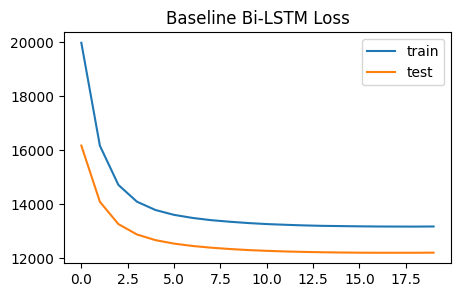

In [ ]:
plt.figure(figsize=(5,3))
plt.title('Baseline Bi-LSTM Loss')
plt.plot(bilstm_model_history.history['loss'], label='train')
plt.plot(bilstm_model_history.history['val_loss'], label='test')
plt.legend()
plt.show();

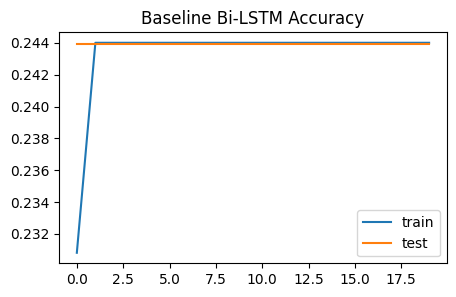

In [ ]:
plt.figure(figsize=(5,3))
plt.title('Baseline Bi-LSTM Accuracy')
plt.plot(bilstm_model_history.history['accuracy'], label='train')
plt.plot(bilstm_model_history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
def generate_text(model,tokenizer,text_seq_length,seed_text,n_words):
    text = []
    for i in range(n_words):
        encoded = tokenizer.texts_to_sequences([seed_text])[0]
        encoded = pad_sequences([encoded],maxlen = text_seq_length,truncating = 'pre')
        
        y_predict = np.argmax(model.predict(encoded),axis=1)

        predicted_word = " "

        for word,index in tokenizer.word_index.items():
            if np.any(index == y_predict):
                predicted_word = word
                break
        seed_text = seed_text + " " + predicted_word
        text.append(predicted_word)
    return " ".join(text)

In [ ]:
sentence_idx = 2
input_text = x_train_sentences[sentence_idx] 
print("Input text: ", input_text)

output_text = generate_text(bilstm_model,tokenizer,50,input_text,70)
print(output_text) 

Input text:  Miss Weeks decided the class should put on a school play. She asked the class which play to do and they decided on Cinderella. Amber was cast as Cinderella, and Peter was the handsome prince. Amber and Peter had to learn lots of words for the play.
1/1 [==============================] - 0s 25ms/step
angela fire fire alicia i'll total bummed dresser zoning fixes wept jacky exercise homemade drinking considering boarding stash sonny hauled hopes convert cakes ranch dan's dan's beaming georgina everybody swallowed everybody overdraft frantically passed triumphantly triumphantly talented hugged hugged linda's linda's luggage thus beforehand television bar responsibility house's road ocd couples' cartwheels bar greens greens eclairs drowning salary extended mental within defied 10 shelley interest many flower stumbled 3000 comfortable


In [ ]:
# Function to count repeated words
def repeated_words(text):
  reg = re.compile('\S{4,}')
  count_repeated_words = Counter(ma.group() for ma in reg.finditer(output_text))
  return print(count_repeated_words)

In [ ]:
# Repeated words from baseline model
repeated_words(output_text)

Counter({'fire': 2, "dan's": 2, 'everybody': 2, 'triumphantly': 2, 'hugged': 2, "linda's": 2, 'greens': 2, 'angela': 1, 'alicia': 1, "i'll": 1, 'total': 1, 'bummed': 1, 'dresser': 1, 'zoning': 1, 'fixes': 1, 'wept': 1, 'jacky': 1, 'exercise': 1, 'homemade': 1, 'drinking': 1, 'considering': 1, 'boarding': 1, 'stash': 1, 'sonny': 1, 'hauled': 1, 'hopes': 1, 'convert': 1, 'cakes': 1, 'ranch': 1, 'beaming': 1, 'georgina': 1, 'swallowed': 1, 'overdraft': 1, 'frantically': 1, 'passed': 1, 'talented': 1, 'luggage': 1, 'thus': 1, 'beforehand': 1, 'television': 1, 'responsibility': 1, "house's": 1, 'road': 1, "couples'": 1, 'cartwheels': 1, 'eclairs': 1, 'drowning': 1, 'salary': 1, 'extended': 1, 'mental': 1, 'within': 1, 'defied': 1, 'shelley': 1, 'interest': 1, 'many': 1, 'flower': 1, 'stumbled': 1, '3000': 1, 'comfortable': 1})



    Hyperparameter Tuning:
        1. Increase parameters
        2. Decrease parameters
        3. Create multiple bi-lstm layers

#####2) Multilayered Bi-LSTM

In [ ]:
# Multi_bilstm with baseline parameters

def create_multi_bilstm_model(max_sequence_length, total_words, n_units):
  bilstm_model = Sequential()

  # Embedding layer stores one vector per word. When called, it converts the sequences
  # of word indices into sequences of vectors. After training, words with similar meanings often have the similar vectors.
  bilstm_model.add(Embedding(total_words, embedding_dim))
    
  # First bidirectional LSTM layer
  bilstm_model.add(Bidirectional(LSTM(n_units, return_sequences=True))),
  # Second bidirectional LSTM layer
  bilstm_model.add(Bidirectional(LSTM(100))),
  bilstm_model.add(Dropout(0.1)) #dropout w/ probability of 10%
    
  bilstm_model.add(Dense(embedding_dim, activation='softmax'))

  bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    
  return bilstm_model

In [ ]:
multi_bilstm_model = create_multi_bilstm_model(max_length, vocab_size, n_units)
multi_bilstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 300)        488400    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 200)              320800    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               51456     
                                                                 
Total params: 3,420,656
Trainable params: 3,420,656
No

In [ ]:
multi_bilstm_history = multi_bilstm_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/20
422/422 [==============================] - 44s 82ms/step - loss: 20101.2012 - accuracy: 0.0830 - val_loss: 16360.3730 - val_accuracy: 0.0857
Epoch 2/20
422/422 [==============================] - 15s 37ms/step - loss: 16317.3018 - accuracy: 0.0830 - val_loss: 14189.0596 - val_accuracy: 0.0857
Epoch 3/20
422/422 [==============================] - 15s 35ms/step - loss: 14785.6494 - accuracy: 0.0830 - val_loss: 13317.0322 - val_accuracy: 0.0857
Epoch 4/20
422/422 [==============================] - 15s 34ms/step - loss: 14134.1377 - accuracy: 0.0983 - val_loss: 12915.4570 - val_accuracy: 0.0857
Epoch 5/20
422/422 [==============================] - 14s 32ms/step - loss: 13817.2822 - accuracy: 0.1319 - val_loss: 12698.4727 - val_accuracy: 0.2439
Epoch 6/20
422/422 [==============================] - 13s 32ms/step - loss: 13635.7715 - accuracy: 0.2440 - val_loss: 12566.9971 - val_accuracy: 0.2439
Epoch 7/20
422/422 [==============================] - 14s 32ms/step - loss: 13517.2100 -

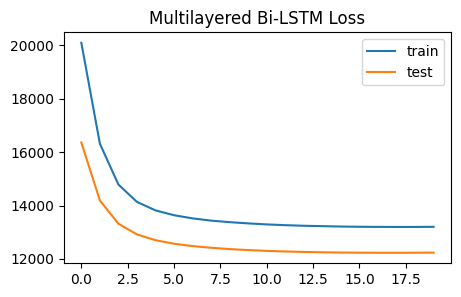

In [ ]:
plt.figure(figsize=(5,3))
plt.title('Multilayered Bi-LSTM Loss')
plt.plot(multi_bilstm_history.history['loss'], label='train')
plt.plot(multi_bilstm_history.history['val_loss'], label='test')
plt.legend()
plt.show();

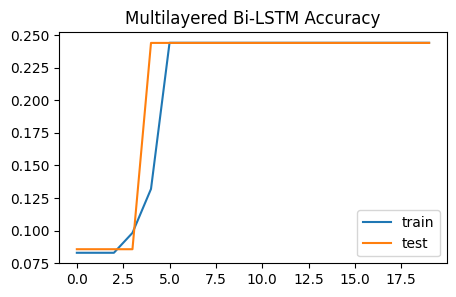

In [ ]:
plt.figure(figsize=(5,3))
plt.title('Multilayered Bi-LSTM Accuracy')
plt.plot(multi_bilstm_history.history['accuracy'], label='train')
plt.plot(multi_bilstm_history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
sentence_idx = 2
input_text = x_train_sentences[sentence_idx] 
print("Input text: ", input_text)

output_text = generate_text(multi_bilstm_model,tokenizer,50,input_text,70)
print(output_text) 

Input text:  Miss Weeks decided the class should put on a school play. She asked the class which play to do and they decided on Cinderella. Amber was cast as Cinderella, and Peter was the handsome prince. Amber and Peter had to learn lots of words for the play.
1/1 [==============================] - 0s 22ms/step
time no no still no take take see i i what thought day day day day day tim tim into by by sam sam quickly quickly play my play play family family family family day day house until getting long water water do ran ran ran trip trip trip trip knew knew knew though are though are new been been said been to out the the became became the said


In [ ]:
repeated_words(output_text)

Counter({'family': 4, 'trip': 4, 'play': 3, 'knew': 3, 'been': 3, 'take': 2, 'quickly': 2, 'water': 2, 'though': 2, 'said': 2, 'became': 2, 'time': 1, 'still': 1, 'what': 1, 'thought': 1, 'into': 1, 'house': 1, 'until': 1, 'getting': 1, 'long': 1})


#####3) Increased Parameters

In [ ]:
increased_params_bilstm_model = create_bilstm_model(max_length, vocab_size, n_units)
increased_params_bilstm_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 1000)        20000000  
                                                                 
 bidirectional_10 (Bidirecti  (None, 600)              3122400   
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 600)               0         
                                                                 
 dense_8 (Dense)             (None, 20000)             12020000  
                                                                 
Total params: 35,142,400
Trainable params: 35,142,400
Non-trainable params: 0
_________________________________________________________________


In [ ]:
increased_params_bilstm_model_history = increased_params_bilstm_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/20
422/422 [==============================] - 58s 123ms/step - loss: 25602.7012 - accuracy: 0.2399 - val_loss: 19546.9336 - val_accuracy: 0.2440
Epoch 2/20
422/422 [==============================] - 32s 76ms/step - loss: 20707.2773 - accuracy: 0.2476 - val_loss: 16964.1660 - val_accuracy: 0.2440
Epoch 3/20
422/422 [==============================] - 28s 67ms/step - loss: 18781.8516 - accuracy: 0.2476 - val_loss: 15929.4395 - val_accuracy: 0.2440
Epoch 4/20
422/422 [==============================] - 29s 69ms/step - loss: 17967.2129 - accuracy: 0.2476 - val_loss: 15444.9668 - val_accuracy: 0.2440
Epoch 5/20
422/422 [==============================] - 29s 68ms/step - loss: 17551.8555 - accuracy: 0.2476 - val_loss: 15173.7393 - val_accuracy: 0.2440
Epoch 6/20
422/422 [==============================] - 28s 67ms/step - loss: 17306.6211 - accuracy: 0.2476 - val_loss: 15008.7793 - val_accuracy: 0.2440
Epoch 7/20
422/422 [==============================] - 28s 66ms/step - loss: 17150.8887 

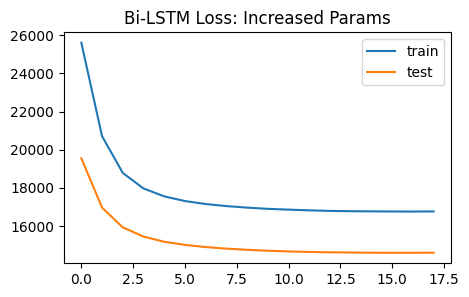

In [ ]:
plt.figure(figsize=(5,3))
plt.title('Bi-LSTM Loss: Increased Params')
plt.plot(increased_params_bilstm_model_history.history['loss'], label='train')
plt.plot(increased_params_bilstm_model_history.history['val_loss'], label='test')
plt.legend()
plt.show();

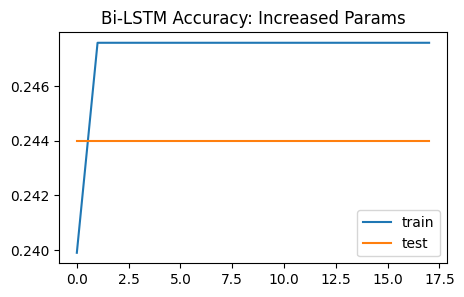

In [ ]:
plt.figure(figsize=(5,3))
plt.title('Bi-LSTM Accuracy: Increased Params')
plt.plot(increased_params_bilstm_model_history.history['accuracy'], label='train')
plt.plot(increased_params_bilstm_model_history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
sentence_idx = 2
input_text = x_train_sentences[sentence_idx] 
print("Input text: ", input_text)

output_text = generate_text(increased_params_bilstm_model,tokenizer,50,input_text,70)
print(output_text) 

Input text:  Miss Weeks decided the class should put on a school play. She asked the class which play to do and they decided on Cinderella. Amber was cast as Cinderella, and Peter was the handsome prince. Amber and Peter had to learn lots of words for the play.
1/1 [==============================] - 0s 22ms/step
buck's businessman joint unwrapped                                                                                                                                    


In [ ]:
repeated_words(output_text)

Counter({"buck's": 1, 'businessman': 1, 'joint': 1, 'unwrapped': 1})


#####4) Decreased Parameters

In [ ]:
decreased_params_bilstm_model = create_bilstm_model(max_length, vocab_size, n_units)
decreased_params_bilstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 50)          25000     
                                                                 
 bidirectional_9 (Bidirectio  (None, 100)              40400     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 500)               50500     
                                                                 
Total params: 115,900
Trainable params: 115,900
Non-trainable params: 0
_________________________________________________________________


In [ ]:
decreased_params_bilstm_model_history = decreased_params_bilstm_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/20
422/422 [==============================] - 25s 44ms/step - loss: 2052.8672 - accuracy: 0.0964 - val_loss: 1770.1864 - val_accuracy: 0.1122
Epoch 2/20
422/422 [==============================] - 6s 15ms/step - loss: 1669.6437 - accuracy: 0.1384 - val_loss: 1567.5381 - val_accuracy: 0.1122
Epoch 3/20
422/422 [==============================] - 5s 12ms/step - loss: 1541.1375 - accuracy: 0.1364 - val_loss: 1492.7205 - val_accuracy: 0.1541
Epoch 4/20
422/422 [==============================] - 6s 15ms/step - loss: 1489.7808 - accuracy: 0.1527 - val_loss: 1458.7012 - val_accuracy: 0.1541
Epoch 5/20
422/422 [==============================] - 5s 12ms/step - loss: 1464.8641 - accuracy: 0.1565 - val_loss: 1440.4668 - val_accuracy: 0.1541
Epoch 6/20
422/422 [==============================] - 6s 15ms/step - loss: 1450.1954 - accuracy: 0.1565 - val_loss: 1429.1775 - val_accuracy: 0.1541
Epoch 7/20
422/422 [==============================] - 6s 14ms/step - loss: 1440.4458 - accuracy: 0.1565 -

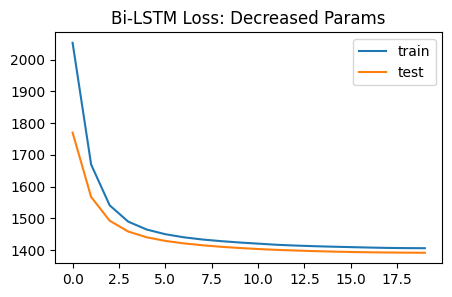

In [ ]:
plt.figure(figsize=(5,3))
plt.title('Bi-LSTM Loss: Decreased Params')
plt.plot(decreased_params_bilstm_model_history.history['loss'], label='train')
plt.plot(decreased_params_bilstm_model_history.history['val_loss'], label='test')
plt.legend()
plt.show();

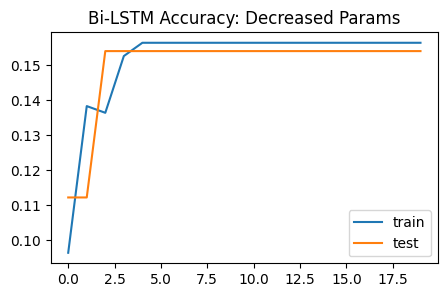

In [ ]:
plt.figure(figsize=(5,3))
plt.title('Bi-LSTM Accuracy: Decreased Params')
plt.plot(decreased_params_bilstm_model_history.history['accuracy'], label='train')
plt.plot(decreased_params_bilstm_model_history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
sentence_idx = 2
input_text = x_train_sentences[sentence_idx] 
print("Input text: ", input_text)

output_text = generate_text(decreased_params_bilstm_model,tokenizer,50,input_text,70)
print(output_text) 

Input text:  Miss Weeks decided the class should put on a school play. She asked the class which play to do and they decided on Cinderella. Amber was cast as Cinderella, and Peter was the handsome prince. Amber and Peter had to learn lots of words for the play.
1/1 [==============================] - 0s 23ms/step
come go go can't can't late fun us not us us knew us care care care care care care on he on him him him him him dress pizza apologized apologized job just something late night night son girl something him wanted great something offered ice knew offered morning ice joe joe ran movie gave joe joe store glad every walked enjoyed enjoyed enjoyed enjoyed enjoyed enjoyed enjoyed turned new


In [ ]:
repeated_words(output_text)

Counter({'enjoyed': 7, 'care': 6, 'something': 3, "can't": 2, 'late': 2, 'knew': 2, 'apologized': 2, 'night': 2, 'offered': 2, 'come': 1, 'dress': 1, 'pizza': 1, 'just': 1, 'girl': 1, 'wanted': 1, 'great': 1, 'morning': 1, 'movie': 1, 'gave': 1, 'store': 1, 'glad': 1, 'every': 1, 'walked': 1, 'turned': 1})


#####5) Decreased Learning Rate

In [ ]:
# Model using baseline params
def create_bilstm_model_lr(max_sequence_length, total_words, n_units):
  bilstm_model_lr = Sequential()
  
  bilstm_model_lr.add(Embedding(vocab_size, embedding_dim))
    
  # First bidirectional LSTM layer
  bilstm_model_lr.add(Bidirectional(LSTM(n_units)))
  bilstm_model_lr.add(Dropout(0.1))
    
  bilstm_model_lr.add(Dense(total_words, activation='softmax'))
  
  #adam default learning rate = 0.001
  #adam = Adam(lr=0.005) #decreased learning rate
  adam = Adam(lr=0.1) #increased learning rate

  bilstm_model_lr.compile(loss='categorical_crossentropy', optimizer=adam, metrics = ['accuracy'])
    
  return bilstm_model_lr

In [ ]:
lr_bilstm_model = create_bilstm_model_lr(max_length, vocab_size, n_units)
lr_bilstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_7 (Bidirectio  (None, 300)              488400    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 300)               0         
                                                                 
 dense_5 (Dense)             (None, 10000)             3010000   
                                                                 
Total params: 6,058,400
Trainable params: 6,058,400
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lr_bilstm_history = lr_bilstm_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/20
422/422 [==============================] - 34s 70ms/step - loss: 19943.2676 - accuracy: 0.2416 - val_loss: 16150.1289 - val_accuracy: 0.2439
Epoch 2/20
422/422 [==============================] - 11s 27ms/step - loss: 16149.9043 - accuracy: 0.2440 - val_loss: 14085.0146 - val_accuracy: 0.2439
Epoch 3/20
422/422 [==============================] - 10s 23ms/step - loss: 14708.5732 - accuracy: 0.2440 - val_loss: 13266.9893 - val_accuracy: 0.2439
Epoch 4/20
422/422 [==============================] - 9s 21ms/step - loss: 14097.5908 - accuracy: 0.2440 - val_loss: 12886.2695 - val_accuracy: 0.2439
Epoch 5/20
422/422 [==============================] - 9s 22ms/step - loss: 13794.3906 - accuracy: 0.2440 - val_loss: 12675.9697 - val_accuracy: 0.2439
Epoch 6/20
422/422 [==============================] - 9s 23ms/step - loss: 13610.1885 - accuracy: 0.2440 - val_loss: 12547.2900 - val_accuracy: 0.2439
Epoch 7/20
422/422 [==============================] - 9s 21ms/step - loss: 13498.0996 - acc

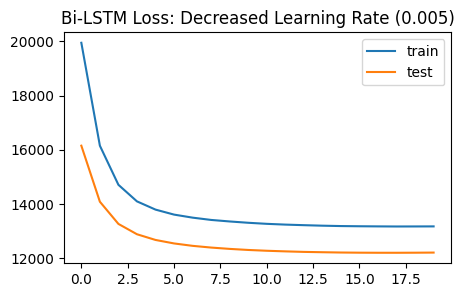

In [ ]:
plt.figure(figsize=(5,3))
plt.title('Bi-LSTM Loss: Decreased Learning Rate (0.005)')
plt.plot(lr_bilstm_history.history['loss'], label='train')
plt.plot(lr_bilstm_history.history['val_loss'], label='test')
plt.legend()
plt.show();

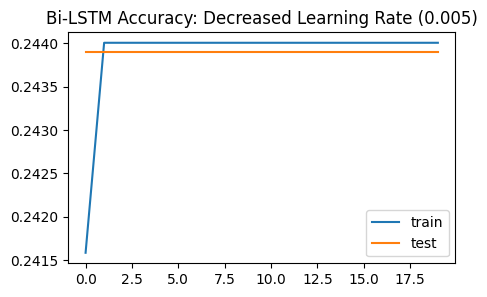

In [ ]:
plt.figure(figsize=(5,3))
plt.title('Bi-LSTM Accuracy: Decreased Learning Rate (0.005)')
plt.plot(lr_bilstm_history.history['accuracy'], label='train')
plt.plot(lr_bilstm_history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
sentence_idx = 2
input_text = x_train_sentences[sentence_idx] 
print("Input text: ", input_text)

output_text = generate_text(lr_bilstm_model,tokenizer,50,input_text,70)
print(output_text) 

Input text:  Miss Weeks decided the class should put on a school play. She asked the class which play to do and they decided on Cinderella. Amber was cast as Cinderella, and Peter was the handsome prince. Amber and Peter had to learn lots of words for the play.
1/1 [==============================] - 0s 19ms/step
times terrible ownership 5 5 harold headboard headboard party intruder tune dishwasher weren't amended massage sweating nine prefers moving printed respond relaxes adulthood adulthood adulthood abs plug kitty ashton repay repay impact ashton tire maxine snaps milestone ensuing call tablet tame gave daughter's avoided suv warrior accomplishments parade detector alligators olaf drank motivation creations creations gracefully shouldn't shouldn't secure history form history history history exact unclogged receiver waiting weather rehearsals


In [ ]:
repeated_words(output_text)

Counter({'history': 4, 'adulthood': 3, 'headboard': 2, 'ashton': 2, 'repay': 2, 'creations': 2, "shouldn't": 2, 'times': 1, 'terrible': 1, 'ownership': 1, 'harold': 1, 'party': 1, 'intruder': 1, 'tune': 1, 'dishwasher': 1, "weren't": 1, 'amended': 1, 'massage': 1, 'sweating': 1, 'nine': 1, 'prefers': 1, 'moving': 1, 'printed': 1, 'respond': 1, 'relaxes': 1, 'plug': 1, 'kitty': 1, 'impact': 1, 'tire': 1, 'maxine': 1, 'snaps': 1, 'milestone': 1, 'ensuing': 1, 'call': 1, 'tablet': 1, 'tame': 1, 'gave': 1, "daughter's": 1, 'avoided': 1, 'warrior': 1, 'accomplishments': 1, 'parade': 1, 'detector': 1, 'alligators': 1, 'olaf': 1, 'drank': 1, 'motivation': 1, 'gracefully': 1, 'secure': 1, 'form': 1, 'exact': 1, 'unclogged': 1, 'receiver': 1, 'waiting': 1, 'weather': 1, 'rehearsals': 1})


#####6) Increased learning rate

In [ ]:
increase_lr_bilstm_model = create_bilstm_model_lr(max_length, vocab_size, n_units)
increase_lr_bilstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_8 (Bidirectio  (None, 300)              488400    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 300)               0         
                                                                 
 dense_6 (Dense)             (None, 10000)             3010000   
                                                                 
Total params: 6,058,400
Trainable params: 6,058,400
Non-trainable params: 0
_________________________________________________________________


In [ ]:
increase_lr_bilstm_history = increase_lr_bilstm_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/20
422/422 [==============================] - 36s 73ms/step - loss: 19947.0156 - accuracy: 0.1723 - val_loss: 16144.0684 - val_accuracy: 0.2439
Epoch 2/20
422/422 [==============================] - 13s 31ms/step - loss: 16144.8877 - accuracy: 0.2440 - val_loss: 14080.5527 - val_accuracy: 0.2439
Epoch 3/20
422/422 [==============================] - 10s 23ms/step - loss: 14703.8203 - accuracy: 0.2440 - val_loss: 13265.9854 - val_accuracy: 0.2439
Epoch 4/20
422/422 [==============================] - 10s 23ms/step - loss: 14096.3574 - accuracy: 0.2440 - val_loss: 12888.1934 - val_accuracy: 0.2439
Epoch 5/20
422/422 [==============================] - 10s 23ms/step - loss: 13794.4248 - accuracy: 0.2440 - val_loss: 12683.1445 - val_accuracy: 0.2439
Epoch 6/20
422/422 [==============================] - 9s 20ms/step - loss: 13620.0557 - accuracy: 0.2440 - val_loss: 12556.2412 - val_accuracy: 0.2439
Epoch 7/20
422/422 [==============================] - 10s 24ms/step - loss: 13509.2207 - 

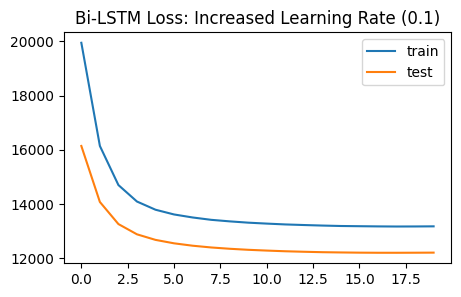

In [ ]:
plt.figure(figsize=(5,3))
plt.title('Bi-LSTM Loss: Increased Learning Rate (0.1)')
plt.plot(increase_lr_bilstm_history.history['loss'], label='train')
plt.plot(increase_lr_bilstm_history.history['val_loss'], label='test')
plt.legend()
plt.show();

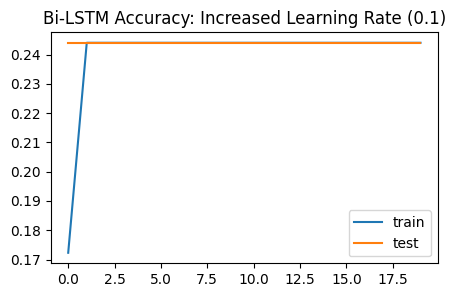

In [ ]:
plt.figure(figsize=(5,3))
plt.title('Bi-LSTM Accuracy: Increased Learning Rate (0.1)')
plt.plot(increase_lr_bilstm_history.history['accuracy'], label='train')
plt.plot(increase_lr_bilstm_history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
sentence_idx = 2
input_text = x_train_sentences[sentence_idx] 
print("Input text: ", input_text)

output_text = generate_text(increase_lr_bilstm_model,tokenizer,50,input_text,70)
print(output_text) 

Input text:  Miss Weeks decided the class should put on a school play. She asked the class which play to do and they decided on Cinderella. Amber was cast as Cinderella, and Peter was the handsome prince. Amber and Peter had to learn lots of words for the play.
1/1 [==============================] - 0s 34ms/step
result changes result kelly's difficult businessman mags kittens insects designs dirk paycheck independence cautious calmly calmly professor calmly cookbook brock segment segment brock cannonball cannonball cannonball stray grounds stray duncan remorse wipers babysitting concluding gravel pacemaker gravel pacemaker hysterically creepy circuits circuits strawberries intense amanda's upstairs upstairs upstairs upstairs looked documents documents documents bart's bart's contrite betraying rage look look look skateboarded george george coat hummingbird 70 70 effort swap


In [ ]:
repeated_words(output_text)

Counter({'upstairs': 4, 'calmly': 3, 'cannonball': 3, 'documents': 3, 'look': 3, 'result': 2, 'brock': 2, 'segment': 2, 'stray': 2, 'gravel': 2, 'pacemaker': 2, 'circuits': 2, "bart's": 2, 'george': 2, 'changes': 1, "kelly's": 1, 'difficult': 1, 'businessman': 1, 'mags': 1, 'kittens': 1, 'insects': 1, 'designs': 1, 'dirk': 1, 'paycheck': 1, 'independence': 1, 'cautious': 1, 'professor': 1, 'cookbook': 1, 'grounds': 1, 'duncan': 1, 'remorse': 1, 'wipers': 1, 'babysitting': 1, 'concluding': 1, 'hysterically': 1, 'creepy': 1, 'strawberries': 1, 'intense': 1, "amanda's": 1, 'looked': 1, 'contrite': 1, 'betraying': 1, 'rage': 1, 'skateboarded': 1, 'coat': 1, 'hummingbird': 1, 'effort': 1, 'swap': 1})


#### BI-LSTM Evaluation for 6 Models

In [ ]:
#sample_y_test = str(y_test[0:100])
sample_y_test = y_test_sentences[0:100]
print(len(sample_y_test))

100


In [ ]:
seed_text = str(x_test_sentences[:100])
bilstm_generated_text = []
for i in range(100):
  #seed_text initial words to be passed for text gen
  encoded = tokenizer.texts_to_sequences([seed_text])[0]
  
  # pad sequences
  encoded = pad_sequences([encoded],maxlen = 50,truncating = 'pre')
  
  # model.predict returns the token id for the predicted word
  y_predict = np.argmax(increased_params_bilstm_model.predict(encoded),axis=1)

  #word_index converts back into a word using word_index
  predicted_word = " "
  for word,index in tokenizer.word_index.items():
    if np.any(index == y_predict):
      predicted_word = word
      break
  seed_text = seed_text + " " + predicted_word
  
  #appends to bilstm_generated_text
  bilstm_generated_text.append(predicted_word)
  " ".join(bilstm_generated_text)

1/1 [==============================] - 0s 32ms/step


In [ ]:
## 1) BLEURT - Baseline BiLSTM
import bleurt
from bleurt import score

references = tf.constant(sample_y_test) #correct results
candidates = tf.constant(bilstm_generated_text) #generated 5th sentence

bleurt_ops = score.create_bleurt_ops()
bleurt_out = bleurt_ops(references=references, candidates=candidates)

assert bleurt_out["predictions"].shape == (100,)
print(bleurt_out["predictions"],'\n')
print("Model 1 Average BLEURT score: ", sum(bleurt_out["predictions"])/100)

tf.Tensor(
[-1.3189173  -1.5069213  -1.2605741  -1.5946915  -1.3756185  -1.5012109
 -1.3391716  -1.3174986  -1.3576329  -1.4748555  -1.105574   -1.176768
 -1.4947779  -1.2286614  -1.2222141  -1.0688174  -1.1576989  -1.5384654
 -1.4651157  -1.4753757  -1.326781   -1.3629558  -1.2880213  -1.3644319
 -1.153838   -1.5441842  -1.4722722  -1.3288405  -1.3114917  -1.3413246
 -1.282016   -1.3829042  -1.361865   -1.2112901  -1.3102696  -1.4075503
 -1.3660412  -1.5063334  -1.3712648  -1.3402556  -1.294855   -1.3416898
 -1.288113   -1.3526484  -1.3735528  -1.4012358  -1.4231088  -1.3694587
 -1.484486   -1.4429996  -1.5063184  -1.3567483  -1.4700896  -1.5016536
 -1.3730173  -1.5372362  -1.3280796  -1.4444041  -1.2189192  -1.4065285
 -1.355281   -1.1001294  -1.3024358  -1.3414202  -1.3636272  -1.3408058
 -0.9930885  -0.93697727 -1.4138144  -1.3550042  -1.4016362  -1.2778916
 -1.3755964  -1.3726153  -0.81542194 -1.2039429  -0.99267876 -1.3298793
 -1.4056451  -1.2315705  -1.3258104  -1.4715419  -1.30

In [ ]:
## 1) ROUGE - Baseline Bi-LSTM

rouge = Rouge()

# Generate a set of sentences from your model
generated_sentences = bilstm_generated_text

# Provide a set of reference sentences to compare against
reference_sentences = sample_y_test

# Compute the ROUGE scores
scores = rouge.get_scores(generated_sentences, reference_sentences, avg=True)

# Print scores in a prettier format
print("Model 1 ROUGE scores")
print("ROUGE-1: ")
print(f"  Precision: {scores['rouge-1']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-1']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-1']['f']*100:.2f}%\n")
print("ROUGE-2: ")
print(f"  Precision: {scores['rouge-2']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-2']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-2']['f']*100:.2f}%\n")
print("ROUGE-L: ")
print(f"  Precision: {scores['rouge-l']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-l']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-l']['f']*100:.2f}%")

Model 1 ROUGE scores
ROUGE-1: 
  Precision: 0.00%
  Recall: 0.00%
  F1 score: 0.00%

ROUGE-2: 
  Precision: 0.00%
  Recall: 0.00%
  F1 score: 0.00%

ROUGE-L: 
  Precision: 0.00%
  Recall: 0.00%
  F1 score: 0.00%


In [ ]:
## 2) BLEURT - Multilayered BiLSTM
import bleurt
from bleurt import score

references = tf.constant(sample_y_test) #correct results
candidates = tf.constant(bilstm_generated_text) #generated 5th sentence

bleurt_ops = score.create_bleurt_ops()
bleurt_out = bleurt_ops(references=references, candidates=candidates)

assert bleurt_out["predictions"].shape == (100,)
print(bleurt_out["predictions"],'\n')
print("Model 1 Average BLEURT score: ", sum(bleurt_out["predictions"])/100)

tf.Tensor(
[-1.4767735  -1.3295197  -1.3084261  -1.4476922  -1.3854985  -1.3929152
 -1.342042   -1.329545   -1.3170747  -1.3785987  -1.0719056  -1.2450695
 -1.4267327  -1.2675011  -1.4048191  -1.1066382  -1.3489275  -1.3846077
 -1.3792768  -1.4005129  -1.3320398  -1.3670932  -1.387393   -1.273673
 -1.2210467  -1.4244188  -1.3968081  -1.4706273  -1.2990319  -1.2882532
 -0.84338284 -1.3229752  -1.3432655  -1.2489917  -1.3636589  -1.3603295
 -1.1328471  -1.0885289  -1.1417056  -0.7529455  -1.2014039  -1.1789274
 -1.2904223  -1.2516555  -1.3162417  -1.3979304  -1.3009977  -1.3726076
 -1.1531587  -1.386963   -1.3310008  -1.3107039  -1.3977535  -1.3665323
 -1.3522121  -1.3677241  -1.3516823  -0.91329455 -1.254371   -1.317541
 -1.3391011  -1.3463086  -1.3378911  -1.3799412  -0.86971915 -1.3755515
 -1.378098   -1.2934195  -1.2791567  -1.3460662  -1.325348   -1.3231627
 -1.4249458  -1.4310484  -1.3800312  -0.89849365 -1.124607   -0.7317379
 -1.3385186  -1.2581762  -1.3851864  -1.3437941  -0.929

In [ ]:
## 2) ROUGE - Multilayered Bi-LSTM

rouge = Rouge()

# Generate a set of sentences from your model
generated_sentences = bilstm_generated_text

# Provide a set of reference sentences to compare against
reference_sentences = sample_y_test

# Compute the ROUGE scores
scores = rouge.get_scores(generated_sentences, reference_sentences, avg=True)

# Print scores in a prettier format
print("Model 1 ROUGE scores")
print("ROUGE-1: ")
print(f"  Precision: {scores['rouge-1']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-1']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-1']['f']*100:.2f}%\n")
print("ROUGE-2: ")
print(f"  Precision: {scores['rouge-2']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-2']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-2']['f']*100:.2f}%\n")
print("ROUGE-L: ")
print(f"  Precision: {scores['rouge-l']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-l']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-l']['f']*100:.2f}%")

Model 1 ROUGE scores
ROUGE-1: 
  Precision: 1.00%
  Recall: 0.08%
  F1 score: 0.14%

ROUGE-2: 
  Precision: 0.00%
  Recall: 0.00%
  F1 score: 0.00%

ROUGE-L: 
  Precision: 1.00%
  Recall: 0.08%
  F1 score: 0.14%


In [ ]:
## 3) BLEURT - Increased Hyperparameters
import bleurt
from bleurt import score

references = tf.constant(sample_y_test) #correct results
candidates = tf.constant(bilstm_generated_text) #generated 5th sentence

bleurt_ops = score.create_bleurt_ops()
bleurt_out = bleurt_ops(references=references, candidates=candidates)

assert bleurt_out["predictions"].shape == (100,)
print(bleurt_out["predictions"],'\n')
print("Model 1 Average BLEURT score: ", sum(bleurt_out["predictions"])/100)

tf.Tensor(
[-0.59164953 -0.6424663  -0.6051153  -0.77060926 -0.7826365  -0.6537247
 -0.7077422  -0.6815118  -0.5749036  -0.6203084  -0.7151903  -0.66109276
 -0.70278883 -0.5870446  -0.71753234 -0.6669234  -0.6151246  -0.6396746
 -0.7709292  -0.7407609  -0.63133967 -0.7210945  -0.7082337  -0.55939865
 -0.5514232  -0.79055226 -0.69559014 -0.66288555 -0.596926   -0.6924864
 -0.5766632  -0.57060695 -0.654537   -0.47033948 -0.66102946 -0.65339994
 -0.70833576 -0.61683285 -0.61406493 -0.6288748  -0.68401086 -0.5841334
 -0.63947564 -0.7116101  -0.7041162  -0.7471401  -0.672034   -0.7644039
 -0.6605757  -0.62247705 -0.73301274 -0.6858345  -0.6565176  -0.70478696
 -0.5572238  -0.663553   -0.6230799  -0.6928091  -0.54888904 -0.59283185
 -0.6450764  -0.6015346  -0.78768927 -0.61961347 -0.64146227 -0.6959528
 -0.7460928  -0.7091719  -0.5947529  -0.6944262  -0.6899289  -0.7116399
 -0.7928163  -0.7066793  -0.61851823 -0.5998591  -0.689171   -0.6124042
 -0.6926354  -0.6190484  -0.6684849  -0.6464637 

In [ ]:
## 3) ROUGE - Increased Hyperparameters

rouge = Rouge()

# Generate a set of sentences from your model
generated_sentences = bilstm_generated_text

# Provide a set of reference sentences to compare against
reference_sentences = sample_y_test

# Compute the ROUGE scores
scores = rouge.get_scores(generated_sentences, reference_sentences, avg=True)

# Print scores in a prettier format
print("Model 1 ROUGE scores")
print("ROUGE-1: ")
print(f"  Precision: {scores['rouge-1']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-1']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-1']['f']*100:.2f}%\n")
print("ROUGE-2: ")
print(f"  Precision: {scores['rouge-2']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-2']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-2']['f']*100:.2f}%\n")
print("ROUGE-L: ")
print(f"  Precision: {scores['rouge-l']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-l']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-l']['f']*100:.2f}%")

Model 1 ROUGE scores
ROUGE-1: 
  Precision: 0.00%
  Recall: 0.00%
  F1 score: 0.00%

ROUGE-2: 
  Precision: 0.00%
  Recall: 0.00%
  F1 score: 0.00%

ROUGE-L: 
  Precision: 0.00%
  Recall: 0.00%
  F1 score: 0.00%


In [ ]:
## 4) BLEURT - Decreased Hyperparameters
import bleurt
from bleurt import score

references = tf.constant(sample_y_test) #correct results
candidates = tf.constant(bilstm_generated_text) #generated 5th sentence

bleurt_ops = score.create_bleurt_ops()
bleurt_out = bleurt_ops(references=references, candidates=candidates)

assert bleurt_out["predictions"].shape == (100,)
print(bleurt_out["predictions"],'\n')
print("Model 1 Average BLEURT score: ", sum(bleurt_out["predictions"])/100)

tf.Tensor(
[-1.3309938  -1.3968153  -1.1383832  -1.4390345  -1.1516057  -1.1222557
 -1.3594158  -1.1974593  -1.1199089  -1.4402121  -1.2567823  -0.97468615
 -1.369096   -1.2935195  -1.3925116  -1.3733186  -1.3912969  -1.3819958
 -1.0609646  -1.136333   -1.3196313  -1.3598864  -1.3266     -1.2307401
 -1.3095732  -1.337806   -1.4272175  -1.4039879  -1.4435321  -1.1829854
 -1.2354934  -1.4214301  -1.35848    -1.2272255  -1.3481725  -1.4431342
 -1.4412252  -1.4425691  -1.3941395  -1.3195096  -1.2342567  -1.272501
 -1.2658503  -1.2627989  -1.397501   -1.3618602  -1.2287121  -1.2918594
 -1.3626221  -1.1021044  -1.4939587  -1.4300716  -1.4846884  -1.3262113
 -1.3622237  -1.3892738  -1.3863944  -1.4057285  -0.8635948  -1.3314803
 -1.3487588  -1.3020129  -1.3585861  -1.3997741  -1.4047499  -1.3112295
 -1.0933406  -1.4456284  -1.4070998  -1.4594386  -1.4446408  -1.3399708
 -1.5157388  -1.4340904  -1.4517181  -1.3419864  -1.3966922  -1.3128616
 -1.4219949  -1.255514   -1.3156224  -1.2270768  -1.2

In [ ]:
## 4) ROUGE - Decreased Hyperparameters

rouge = Rouge()

# Generate a set of sentences from your model
generated_sentences = bilstm_generated_text

# Provide a set of reference sentences to compare against
reference_sentences = sample_y_test

# Compute the ROUGE scores
scores = rouge.get_scores(generated_sentences, reference_sentences, avg=True)

# Print scores in a prettier format
print("Model 1 ROUGE scores")
print("ROUGE-1: ")
print(f"  Precision: {scores['rouge-1']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-1']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-1']['f']*100:.2f}%\n")
print("ROUGE-2: ")
print(f"  Precision: {scores['rouge-2']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-2']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-2']['f']*100:.2f}%\n")
print("ROUGE-L: ")
print(f"  Precision: {scores['rouge-l']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-l']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-l']['f']*100:.2f}%")

Model 1 ROUGE scores
ROUGE-1: 
  Precision: 0.00%
  Recall: 0.00%
  F1 score: 0.00%

ROUGE-2: 
  Precision: 0.00%
  Recall: 0.00%
  F1 score: 0.00%

ROUGE-L: 
  Precision: 0.00%
  Recall: 0.00%
  F1 score: 0.00%


In [ ]:
## 5) BLEURT - Decreased Learning Rate
import bleurt
from bleurt import score

references = tf.constant(sample_y_test) #correct results
candidates = tf.constant(bilstm_generated_text) #generated 5th sentence

bleurt_ops = score.create_bleurt_ops()
bleurt_out = bleurt_ops(references=references, candidates=candidates)

assert bleurt_out["predictions"].shape == (100,)
print(bleurt_out["predictions"],'\n')
print("Model 1 Average BLEURT score: ", sum(bleurt_out["predictions"])/100)

tf.Tensor(
[-1.2451122 -1.3596416 -1.2479529 -1.5501254 -1.3991082 -1.1561497
 -1.4645507 -1.2554939 -1.2314435 -1.4812201 -1.4960647 -1.4520423
 -1.4953873 -1.4595113 -1.3362286 -1.4547435 -1.283236  -1.2557734
 -1.3033308 -1.4290519 -1.3136276 -1.3435504 -1.2721308 -1.261184
 -1.3893812 -1.3264983 -1.4639847 -1.4865602 -1.3816588 -1.3612772
 -1.3282328 -1.4233527 -1.4317338 -1.2017094 -1.2851418 -1.2999978
 -1.4881849 -1.1440107 -1.2164538 -1.1996286 -1.2218769 -1.4256386
 -1.280576  -1.3777022 -1.0370746 -1.4639736 -1.4518466 -1.3273695
 -1.3971859 -1.4158206 -1.3516707 -1.3208956 -1.3776351 -1.3594558
 -1.4303306 -1.385137  -1.293597  -1.5177443 -1.2840931 -1.3947992
 -1.4323478 -1.3768843 -1.3736511 -1.4932792 -1.30726   -1.318219
 -1.5154527 -1.2780201 -1.3026502 -1.2924347 -1.4074754 -1.43875
 -1.4771686 -1.3067845 -1.3150986 -1.39973   -1.2884332 -1.2351213
 -1.5321581 -1.2746323 -1.5128739 -1.5155742 -1.2958822 -1.3798308
 -1.4044429 -1.3989171 -1.3886721 -1.318323  -1.4196182

In [ ]:
## 5) ROUGE - Decreased Learning Rate

rouge = Rouge()

# Generate a set of sentences from your model
generated_sentences = bilstm_generated_text

# Provide a set of reference sentences to compare against
reference_sentences = sample_y_test

# Compute the ROUGE scores
scores = rouge.get_scores(generated_sentences, reference_sentences, avg=True)

# Print scores in a prettier format
print("Model 1 ROUGE scores")
print("ROUGE-1: ")
print(f"  Precision: {scores['rouge-1']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-1']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-1']['f']*100:.2f}%\n")
print("ROUGE-2: ")
print(f"  Precision: {scores['rouge-2']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-2']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-2']['f']*100:.2f}%\n")
print("ROUGE-L: ")
print(f"  Precision: {scores['rouge-l']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-l']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-l']['f']*100:.2f}%")

Model 1 ROUGE scores
ROUGE-1: 
  Precision: 0.00%
  Recall: 0.00%
  F1 score: 0.00%

ROUGE-2: 
  Precision: 0.00%
  Recall: 0.00%
  F1 score: 0.00%

ROUGE-L: 
  Precision: 0.00%
  Recall: 0.00%
  F1 score: 0.00%


In [ ]:
## 6) BLEURT - Decreased Learning Rate
import bleurt
from bleurt import score

references = tf.constant(sample_y_test) #correct results
candidates = tf.constant(bilstm_generated_text) #generated 5th sentence

bleurt_ops = score.create_bleurt_ops()
bleurt_out = bleurt_ops(references=references, candidates=candidates)

assert bleurt_out["predictions"].shape == (100,)
print(bleurt_out["predictions"],'\n')
print("Model 1 Average BLEURT score: ", sum(bleurt_out["predictions"])/100)

tf.Tensor(
[-1.196878   -1.4192685  -1.3980194  -1.5710566  -1.416296   -1.3369613
 -1.4141858  -1.272926   -1.3120975  -1.3978754  -1.4589274  -1.4096378
 -1.4590642  -1.3816636  -1.4162983  -1.2482543  -1.365447   -1.4506637
 -1.4294883  -1.4773544  -1.3058192  -1.2852957  -1.40088    -1.4182014
 -1.389754   -1.3793998  -1.3689321  -1.3508303  -1.3534262  -1.4792131
 -1.22437    -1.2891493  -1.4928228  -1.3170742  -1.3951766  -0.9472983
 -1.4323349  -1.2629313  -1.4190155  -1.3098708  -1.376797   -1.4328977
 -1.3492644  -1.5166657  -1.416171   -1.3210539  -1.1881729  -1.4212455
 -1.2508931  -1.4274898  -1.330197   -1.453899   -1.4416678  -1.2752295
 -1.4806852  -1.4090425  -1.4270211  -1.3331873  -1.2589267  -1.4394102
 -1.430942   -1.3469645  -1.299613   -1.4017144  -1.4256741  -1.4540083
 -1.2267253  -1.026556   -1.0936779  -1.1028391  -1.326935   -1.264494
 -1.3870012  -1.4860575  -1.4605145  -1.2374501  -1.2835362  -1.487571
 -1.2025919  -1.4827665  -1.3448687  -1.5146606  -1.367

In [ ]:
## 6) ROUGE - Decreased Learning Rate

rouge = Rouge()

# Generate a set of sentences from your model
generated_sentences = bilstm_generated_text

# Provide a set of reference sentences to compare against
reference_sentences = sample_y_test

# Compute the ROUGE scores
scores = rouge.get_scores(generated_sentences, reference_sentences, avg=True)

# Print scores in a prettier format
print("Model 1 ROUGE scores")
print("ROUGE-1: ")
print(f"  Precision: {scores['rouge-1']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-1']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-1']['f']*100:.2f}%\n")
print("ROUGE-2: ")
print(f"  Precision: {scores['rouge-2']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-2']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-2']['f']*100:.2f}%\n")
print("ROUGE-L: ")
print(f"  Precision: {scores['rouge-l']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-l']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-l']['f']*100:.2f}%")

Model 1 ROUGE scores
ROUGE-1: 
  Precision: 0.00%
  Recall: 0.00%
  F1 score: 0.00%

ROUGE-2: 
  Precision: 0.00%
  Recall: 0.00%
  F1 score: 0.00%

ROUGE-L: 
  Precision: 0.00%
  Recall: 0.00%
  F1 score: 0.00%


Observations: Baseline model did the best. 


*   Had a lower loss than increased params
*   Did not overfit w/ decreased params.
* Multi-layers Bilstm had similar results to original. More layers would be needed to make a difference, but that's not needed for this as it would require more computing power (for little gain)
*  Baseline also had the least repition



####Bi-LSTM Evaluation for Winner Model (500 test set)


*   BLEURT
*   ROUGE



In [ ]:
#sample_y_test = str(y_test[0:100])
sample_y_test = y_test_sentences[0:500]
print(len(sample_y_test))

500


In [ ]:
seed_text = str(x_test_sentences[:500])
bilstm_generated_text = []
for i in range(500):
  #seed_text initial words to be passed for text gen
  encoded = tokenizer.texts_to_sequences([seed_text])[0]
  
  # pad sequences
  encoded = pad_sequences([encoded],maxlen = 50,truncating = 'pre')
  
  # model.predict returns the token id for the predicted word
  y_predict = np.argmax(bilstm_model.predict(encoded),axis=1)

  #word_index converts back into a word using word_index
  predicted_word = " "
  for word,index in tokenizer.word_index.items():
    if np.any(index == y_predict):
      predicted_word = word
      break
  seed_text = seed_text + " " + predicted_word
  
  #appends to text
  bilstm_generated_text.append(predicted_word)
  " ".join(bilstm_generated_text)

1/1 [==============================] - 0s 18ms/step


In [ ]:
## BLEURT
import bleurt
from bleurt import score

references = tf.constant(sample_y_test) #correct results
candidates = tf.constant(bilstm_generated_text) #generated 5th sentence

bleurt_ops = score.create_bleurt_ops()
bleurt_out = bleurt_ops(references=references, candidates=candidates)

assert bleurt_out["predictions"].shape == (500,)
print(bleurt_out["predictions"],'\n')
print("Model 1 Average BLEURT score: ", sum(bleurt_out["predictions"])/500)

tf.Tensor(
[-1.3025105  -1.3932073  -1.2607582  -1.3495889  -1.4843618  -1.3395337
 -0.910658   -1.4321231  -1.480306   -1.4176588  -1.4790852  -1.3063244
 -1.5550286  -1.5004044  -1.4267422  -1.3750091  -1.3568237  -1.3198041
 -1.4386177  -1.4801705  -1.4626538  -1.3299124  -1.4186932  -1.37684
 -1.2665799  -1.3471987  -1.4390106  -1.4994388  -1.5318253  -1.1579348
 -1.3745973  -1.2544158  -1.2820623  -1.3960366  -1.4627869  -1.3666878
 -1.4082611  -1.2094986  -1.446177   -1.4353867  -1.290705   -1.4574974
 -1.334487   -1.4590507  -1.3119897  -1.3827283  -1.344176   -1.292208
 -0.90985656 -1.4618504  -1.0534813  -1.0048325  -1.2637022  -1.0261759
 -1.3564808  -1.473876   -1.2507758  -1.401714   -1.31285    -1.2960663
 -1.3484595  -1.3099794  -1.4461129  -1.3142686  -1.286835   -1.4261656
 -1.3719606  -1.4212437  -1.3964592  -1.3846774  -1.1685412  -1.3817606
 -1.315872   -1.4118724  -1.410934   -0.6345217  -1.4798068  -1.4061724
 -1.3939725  -1.3621092  -1.3454235  -1.265253   -1.2264

In [ ]:
## ROUGE

rouge = Rouge()

# Generate a set of sentences from your model
generated_sentences = bilstm_generated_text

# Provide a set of reference sentences to compare against
reference_sentences = sample_y_test

# Compute the ROUGE scores
scores = rouge.get_scores(generated_sentences, reference_sentences, avg=True)

# Print scores in a prettier format
print("Model 1 ROUGE scores")
print("ROUGE-1: ")
print(f"  Precision: {scores['rouge-1']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-1']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-1']['f']*100:.2f}%\n")
print("ROUGE-2: ")
print(f"  Precision: {scores['rouge-2']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-2']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-2']['f']*100:.2f}%\n")
print("ROUGE-L: ")
print(f"  Precision: {scores['rouge-l']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-l']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-l']['f']*100:.2f}%")

Model 1 ROUGE scores
ROUGE-1: 
  Precision: 0.00%
  Recall: 0.00%
  F1 score: 0.00%

ROUGE-2: 
  Precision: 0.00%
  Recall: 0.00%
  F1 score: 0.00%

ROUGE-L: 
  Precision: 0.00%
  Recall: 0.00%
  F1 score: 0.00%


#### BERT Encoder

    Create BERT model with standard hyperparameters
    
    Hyperparameter Tuning:
        1. Standar Hyperparameters
        2. Dropout, Weight decay
        3. Beam search
        4. Top-p
    
    Compare BLEURT/ROUGE scores

In [ ]:
x_train_sub = df_train['X'].astype(str).head(5000).values.tolist()
y_train_sub = df_train['sentence5'].astype(str).head(5000).values.tolist()
df_train_sub = df_train.head(5000)

x_test_sub = df_test['X'].astype(str).head(100).values.tolist()
y_test_sub = df_test['sentence5'].astype(str).head(100).values.tolist()
df_test_sub = df_test.head(100)

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM, AdamW

bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bert_model = bert_model.to(device)


In [ ]:
def generate_sentence(prompt, ending, tokenizer, model, device):
    # Encode the prompt using the tokenizer
    inputs = bert_tokenizer.encode(prompt, return_tensors='pt').to(device)

    # Get the masked token index
    masked_index = torch.where(inputs == bert_tokenizer.mask_token_id)[1]

    # Generate the next sentence
    output = bert_model.generate(inputs, max_length=75, do_sample=True)

    output_sentence = bert_tokenizer.decode(output[0], skip_special_tokens=True)

    return output_sentence


In [ ]:
import csv

# Open a CSV file to write the output sentences
with open('bert-output.csv', mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    # Write the header row
    writer.writerow(['Prompt', 'Ending', 'Output'])

    # generate outputs for the test prompts and endings
    for prompt, ending in zip(x_test_sub, y_test_sub):
        output_sentence = generate_sentence(prompt, ending, bert_tokenizer, bert_model, device)
        # Print the generated sentence
        # print(prompt)
        # print(ending)
        # print(output_sentence)
        # print()

        # Write the output sentence to the CSV file
        writer.writerow([prompt, ending, output_sentence])

csv_file.close()

In [ ]:
# Create a new list to hold the masked input sentences
masked_sentences = []

# Loop over each input sentence and add [MASK] to the end
for sentence in x_train_sub:
    masked_sentence = sentence + ' [MASK]'
    masked_sentences.append(masked_sentence)
    
    # Print the original and masked sentences for comparison
    # print(f'Original sentence: {sentence}')
    # print(f'Masked sentence:   {masked_sentence}\n')


In [ ]:
# Fine-tuning pass#1 - Model learns using surrounding context

from tqdm import tqdm

device = torch.device("cuda")
bert_model = bert_model.to(device)

def fine_tune_bert(
    x_train, y_train, 
    bert_model, 
    bert_tokenizer, 
    num_epochs=2, 
    batch_size=8, 
    learning_rate=2e-5):
  
    # Set the model to training mode
    bert_model.train()
    
    # Define the optimizer
    optimizer = AdamW(bert_model.parameters(), lr=learning_rate)
    
    # Loop through each epoch
    for epoch in range(num_epochs):

      epoch_loss = 0

      # Wrap the training data in a tqdm progress bar
      with tqdm(total=len(x_train)) as progress_bar:

        # Loop through each training example
        for i in range(len(x_train)):
            # Encode the input and output sequences using the tokenizer
            inputs = bert_tokenizer.encode(x_train[i], return_tensors='pt').to(device)
            labels = bert_tokenizer.encode(y_train[i], return_tensors='pt').to(device)

            # Get the masked token index
            masked_index = torch.where(inputs == bert_tokenizer.mask_token_id)[1]

            # Replace the masked token with the corresponding label token
            # inputs[0, masked_index] = labels[0, masked_index]

            optimizer.zero_grad()

            # Feed the inputs into the model, 
            # labels are the inputs themselves 
            # so the model learns from surrounding context
            outputs = bert_model(inputs, labels=inputs)

            loss = outputs.loss

            # Backpropagate the loss
            loss.backward()

            # Update the weights
            optimizer.step()

            progress_bar.update(1)
            
        # Calculate the average loss for the epoch
        avg_loss = epoch_loss / len(x_train)

        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

fine_tune_bert(masked_sentences, y_train_sub, bert_model, bert_tokenizer)


100%|██████████| 5000/5000 [06:39<00:00, 12.53it/s]


Epoch 1: Loss = 0.0001


100%|██████████| 5000/5000 [05:57<00:00, 13.98it/s]

Epoch 2: Loss = 0.0001


In [ ]:
# Open a CSV file to write the output sentences
with open('bert-output-pass1.csv', mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    # Write the header row
    writer.writerow(['Prompt', 'Ending', 'Output'])

    # generate outputs for the test prompts and endings
    for prompt, ending in zip(x_test_sub, y_test_sub):
        output_sentence = generate_sentence(prompt, ending, bert_tokenizer, bert_model, device)
        # Print the generated sentence
        # print(prompt)
        # print(ending)
        # print(output_sentence)
        # print()

        # Write the output sentence to the CSV file
        writer.writerow([prompt, ending, output_sentence])

csv_file.close()

In [ ]:
# Fine-tuning pass#2 - dropout, weight_decay; training without labels. Model learns using surrounding context
# bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased')

# device = torch.device("cpu")
bert_model = bert_model.to(device)

def fine_tune_bert(
    x_train, 
    y_train, 
    bert_model, 
    bert_tokenizer, 
    num_epochs=3, 
    batch_size=8, 
    learning_rate=2e-5,
    dropout=0.2,
    weight_decay=0.01):

    # Define the BERT model with dropout
    bert_model.config.attention_probs_dropout_prob = dropout
    bert_model.config.hidden_dropout_prob = dropout

    bert_model.train()

    optimizer = AdamW(bert_model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
      epoch_loss = 0

      # Wrap the training data in a tqdm progress bar
      with tqdm(total=len(x_train)) as progress_bar:
        # Loop through each training example
        for i in range(len(x_train)):
            # Encode the input and output sequences using the tokenizer
            inputs = bert_tokenizer.encode(x_train[i], return_tensors='pt').to(device)
            labels = bert_tokenizer.encode(y_train[i], return_tensors='pt').to(device)

            # Get the masked token index
            masked_index = torch.where(inputs == bert_tokenizer.mask_token_id)[1]

            optimizer.zero_grad()

            # Feed the inputs into the model, 
            # labels are the inputs themselves 
            # so the model learns from surrounding context
            outputs = bert_model(inputs, labels=inputs)

            loss = outputs.loss

            # Backpropagate the loss
            loss.backward()

            # Update the weights
            optimizer.step()

            # Add the loss for the current example to the epoch loss
            epoch_loss += loss.item()

            progress_bar.update(1)
            
        # Calculate the average loss for the epoch
        avg_loss = epoch_loss / len(x_train)

        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

fine_tune_bert(masked_sentences, y_train_sub, bert_model, bert_tokenizer)


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 5000/5000 [05:49<00:00, 14.29it/s]


Epoch 1: Loss = 0.0000


100%|██████████| 5000/5000 [05:49<00:00, 14.31it/s]


Epoch 2: Loss = 0.0000


100%|██████████| 5000/5000 [05:50<00:00, 14.27it/s]

Epoch 3: Loss = 0.0000


In [ ]:
import csv

bert_model.eval()

# Open a CSV file to write the output sentences
with open('bert-output-pass2.csv', mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    # Write the header row
    writer.writerow(['Prompt', 'Ending', 'Output'])

    # generate outputs for the test prompts and endings
    for prompt, ending in zip(x_test_sub, y_test_sub):
        output_sentence = generate_sentence(prompt, ending, bert_tokenizer, bert_model, device)
        # Print the generated sentence
        # print(prompt)
        # print(ending)
        # print(output_sentence)
        # print()

        # Write the output sentence to the CSV file
        writer.writerow([prompt, ending, output_sentence])

csv_file.close()

Defining a generate_text_beam_search function that takes a prompt string as input and generates text using beam search with a maximum sequence length of max_length, num_beams beams, and a temperature value of temperature. The generate method of the BERT model takes care of the beam search decoding process, so we don't need to modify the model or decoding process explicitly.

In [ ]:
# Generate using beam search

# Define the function to generate text using beam search
def generate_sentence_beam_search(prompt, bert_tokenizer, bert_model, device, max_length=75, num_beams=3, temperature=1.0):

    bert_model.eval()
    input_ids = bert_tokenizer.encode(prompt, add_special_tokens=True, return_tensors='pt').to(device)

    # Generate text using beam search
    outputs = bert_model.generate(input_ids=input_ids, max_length=max_length, num_beams=num_beams, temperature=temperature)
    text = bert_tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return text


In [ ]:
# Open a CSV file to write the output sentences
with open('bert-output-beam-search.csv', mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    # Write the header row
    writer.writerow(['Prompt', 'Ending', 'Output'])

    # generate outputs for the test prompts and endings
    for prompt, ending in zip(x_test_sub, y_test_sub):
        output_sentence = generate_sentence_beam_search(prompt, bert_tokenizer, bert_model, device)
        # Print the generated sentence
        # print(prompt)
        # print(ending)
        # print(output_sentence)
        # print()

        # Write the output sentence to the CSV file
        writer.writerow([prompt, ending, output_sentence])

csv_file.close()

Defining the generate_text_top_p function that takes a prompt string as input and generates text using top-p sampling with a maximum sequence length of max_length, a top_p value of 0.9, and a temperature value of temperature.

In [ ]:
# Generate using top-p

# Define the function to generate text using top-p sampling
def generate_sentence_top_p(prompt, bert_tokenizer, bert_model, device, max_length=75, top_p=0.9, temperature=1.0):
    # Set the model to evaluation mode
    bert_model.eval()
    input_ids = bert_tokenizer.encode(prompt, add_special_tokens=True, return_tensors='pt').to(device)

    # Generate text using top-p sampling
    outputs = bert_model.generate(input_ids=input_ids, max_length=max_length, do_sample=True, top_p=top_p, temperature=temperature)

    text = bert_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return text


In [ ]:
# Open a CSV file to write the output sentences
with open('bert-output-top-p.csv', mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    # Write the header row
    writer.writerow(['Prompt', 'Ending', 'Output'])

    # generate outputs for the test prompts and endings
    for prompt, ending in zip(x_test_sub, y_test_sub):
        output_sentence = generate_sentence_top_p(prompt, bert_tokenizer, bert_model, device)
        # Print the generated sentence
        # print(prompt)
        # print(ending)
        # print(output_sentence)
        # print()

        # Write the output sentence to the CSV file
        writer.writerow([prompt, ending, output_sentence])

csv_file.close()

#### BERT Model Evaluation:
- BLEURT
- ROUGE

In [ ]:
!pip install git+https://github.com/google-research/bleurt.git

In [ ]:
import bleurt
from bleurt import score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bleurt_scorer = score.BleurtScorer()

# Evaluate the model on the validation set
scores = []
# for input_text, target_text in zip(x_val, y_val):
for prompt, ending in zip(x_test_sub, y_test_sub):
    # Generate the story ending
    output_sentence = generate_sentence(prompt, ending, bert_tokenizer, bert_model, device)
    # Print input and output for debugging
    # print(f"Input: {input_sentence}")
    # print(f"Output: {output_sentence}\n")

    # Compute the BLEURT score
    bleurt_score = bleurt_scorer.score(references=[output_sentence], candidates=[ending])[0]
    scores.append(bleurt_score)

# Compute the average BLEURT score
avg_bleurt_score = sum(scores) / len(scores)
print("Average BLEURT score:", avg_bleurt_score)

Average BLEURT score: -1.1563386679887773


In [ ]:
import bleurt
from bleurt import score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bleurt_scorer = score.BleurtScorer()

# Evaluate the model on the validation set
scores = []

for prompt, ending in zip(x_test_sub, y_test_sub):
    # Generate the story ending
    output_sentence = generate_sentence_beam_search(prompt, bert_tokenizer, bert_model, device)
    # Print input and output for debugging
    # print(f"Input: {input_sentence}")
    # print(f"Output: {output_sentence}\n")

    # Compute the BLEURT score
    bleurt_score = bleurt_scorer.score(references=[output_sentence], candidates=[ending])[0]
    scores.append(bleurt_score)

# Compute the average BLEURT score
avg_bleurt_score = sum(scores) / len(scores)
print("Average BLEURT score:", avg_bleurt_score)

Average BLEURT score: -1.161538885474205


In [ ]:
import bleurt
from bleurt import score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bleurt_scorer = score.BleurtScorer()

# Evaluate the model on the validation set
scores = []

for prompt, ending in zip(x_test_sub, y_test_sub):
    # Generate the story ending
    output_sentence = generate_sentence_top_p(prompt, bert_tokenizer, bert_model, device)

    # Print input and output for debugging
    # print(f"Input: {input_sentence}")
    # print(f"Output: {output_sentence}\n")

    # Compute the BLEURT score
    bleurt_score = bleurt_scorer.score(references=[output_sentence], candidates=[ending])[0]
    scores.append(bleurt_score)

# Compute the average BLEURT score
avg_bleurt_score = sum(scores) / len(scores)
print("Average BLEURT score:", avg_bleurt_score)

Average BLEURT score: -1.1547109487056733


In [ ]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from rouge import Rouge
rouge = Rouge()

# Define lists to store references and hypothesis
references = []
hypotheses = []

# Generate story endings for the test dataset using the BERT model
for prompt, ending in zip(x_test_sub, y_test_sub):
    # Generate the story ending
    output_sentence = generate_sentence(prompt, ending, bert_tokenizer, bert_model, device)

    references.append(ending)
    hypotheses.append(output_sentence)
    
    # Print input and output for debugging
    # print(f"Input: {input_text}")
    # print(f"Output: {output_text}\n")

# Evaluate using ROUGE
scores = rouge.get_scores(hypotheses, references, avg=True)
print(scores)
print()

# Print scores in a prettier format
print("ROUGE-1: ")
print(f"  Precision: {scores['rouge-1']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-1']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-1']['f']*100:.2f}%\n")
print("ROUGE-2: ")
print(f"  Precision: {scores['rouge-2']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-2']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-2']['f']*100:.2f}%\n")
print("ROUGE-L: ")
print(f"  Precision: {scores['rouge-l']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-l']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-l']['f']*100:.2f}%")

{'rouge-1': {'r': 0.3031254551004551, 'p': 0.09884518424702964, 'f': 0.14703050291321407}, 'rouge-2': {'r': 0.058100604950604914, 'p': 0.013604593040127335, 'f': 0.02170887643877057}, 'rouge-l': {'r': 0.2820179847929852, 'p': 0.0918171810016627, 'f': 0.13661827885723138}}

ROUGE-1: 
  Precision: 9.88%
  Recall: 30.31%
  F1 score: 14.70%

ROUGE-2: 
  Precision: 1.36%
  Recall: 5.81%
  F1 score: 2.17%

ROUGE-L: 
  Precision: 9.18%
  Recall: 28.20%
  F1 score: 13.66%


In [ ]:
from rouge import Rouge
rouge = Rouge()

# Define lists to store references and hypothesis
references = []
hypotheses = []

# Generate story endings for the test dataset using the BERT model
for prompt, ending in zip(x_test_sub, y_test_sub):
    # Generate the story ending
    output_sentence = generate_sentence_beam_search(prompt, bert_tokenizer, bert_model, device)

    references.append(ending)
    hypotheses.append(output_sentence)
    
    # Print input and output for debugging
    # print(f"Input: {input_text}")
    # print(f"Output: {output_text}\n")

# Evaluate using ROUGE
scores = rouge.get_scores(hypotheses, references, avg=True)
print(scores)
print()

# Print scores in a prettier format
print("ROUGE-1: ")
print(f"  Precision: {scores['rouge-1']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-1']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-1']['f']*100:.2f}%\n")
print("ROUGE-2: ")
print(f"  Precision: {scores['rouge-2']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-2']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-2']['f']*100:.2f}%\n")
print("ROUGE-L: ")
print(f"  Precision: {scores['rouge-l']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-l']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-l']['f']*100:.2f}%")

{'rouge-1': {'r': 0.29914481906981916, 'p': 0.10228845810156516, 'f': 0.15034564588294666}, 'rouge-2': {'r': 0.05748155733155729, 'p': 0.01466240654989844, 'f': 0.023014378031026645}, 'rouge-l': {'r': 0.2772960567210571, 'p': 0.09467986076860903, 'f': 0.13920554773075822}}

ROUGE-1: 
  Precision: 10.23%
  Recall: 29.91%
  F1 score: 15.03%

ROUGE-2: 
  Precision: 1.47%
  Recall: 5.75%
  F1 score: 2.30%

ROUGE-L: 
  Precision: 9.47%
  Recall: 27.73%
  F1 score: 13.92%


In [ ]:
from rouge import Rouge
rouge = Rouge()

# Define lists to store references and hypothesis
references = []
hypotheses = []

# Generate story endings for the test dataset using the BERT model
for prompt, ending in zip(x_test_sub, y_test_sub):
    # Generate the story ending
    output_sentence = generate_sentence_top_p(prompt, bert_tokenizer, bert_model, device)
    
    references.append(ending)
    hypotheses.append(output_sentence)
    
    # Print input and output for debugging
    # print(f"Input: {input_text}")
    # print(f"Output: {output_text}\n")

# Evaluate using ROUGE
scores = rouge.get_scores(hypotheses, references, avg=True)
print(scores)
print()

# Print scores in a prettier format
print("ROUGE-1: ")
print(f"  Precision: {scores['rouge-1']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-1']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-1']['f']*100:.2f}%\n")
print("ROUGE-2: ")
print(f"  Precision: {scores['rouge-2']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-2']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-2']['f']*100:.2f}%\n")
print("ROUGE-L: ")
print(f"  Precision: {scores['rouge-l']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-l']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-l']['f']*100:.2f}%")

{'rouge-1': {'r': 0.3004677849927851, 'p': 0.10035793446582113, 'f': 0.1484226243805276}, 'rouge-2': {'r': 0.05748155733155729, 'p': 0.014212407938673028, 'f': 0.022452876289330813}, 'rouge-l': {'r': 0.27968631091131124, 'p': 0.09329010832152494, 'f': 0.1380037977440958}}

ROUGE-1: 
  Precision: 10.04%
  Recall: 30.05%
  F1 score: 14.84%

ROUGE-2: 
  Precision: 1.42%
  Recall: 5.75%
  F1 score: 2.25%

ROUGE-L: 
  Precision: 9.33%
  Recall: 27.97%
  F1 score: 13.80%


#### T5 - Text-to-Text Transfer Transformer

    Create T5 model with standard hyperparameters
    
    Hyperparameter Tuning:
        1. Standard Hyperparameters
        2. Fewer epochs, increased batch size 
        3. SGD optimizer
        4. Dropout
    
    Compare BLEURT/ROUGE scores

In [ ]:
x_train_sub = df_train['X'].astype(str).head(5000).values.tolist()
y_train_sub = df_train['sentence5'].astype(str).head(5000).values.tolist()
df_train_sub = df_train.head(5000)

x_test_sub = df_test['X'].astype(str).head(100).values.tolist()
y_test_sub = df_test['sentence5'].astype(str).head(100).values.tolist()
df_test_sub = df_train.head(100)

In [ ]:
# !pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.1 MB/s eta 0:00:00


In [ ]:
# !pip uninstall transformers

In [ ]:
# !pip install transformers[t5]

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_small_model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
import csv

# Open a CSV file to write the output sentences
with open('t5-output.csv', mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    # Write the header row
    writer.writerow(['Prompt', 'Output'])

    # Generate story endings
    for input in x_test_sub:
        input_text = "Complete the story: " + input
        # Generate the story ending
        input_ids = t5_tokenizer.encode(input_text, return_tensors="pt").to(device)
        output_ids = t5_small_model.generate(input_ids=input_ids, max_length=75, num_beams=5, early_stopping=True)
        output_text = t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)
        # Print the input and generated output
        # print("Input Text: " + input_text)
        # print("Generated Ending: " + output_text)
        # print()

        # Write the output sentence to the CSV file
        writer.writerow([input_text, output_text])

csv_file.close()

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

# custom dataset for x_train and y_train data
class StoryDataset(Dataset):
    def __init__(self, x_train, y_train, t5_tokenizer):
        self.input_ids = []
        self.attention_masks = []
        self.labels = []
        for i in range(len(x_train_sub)):
            input_str = "Complete the story: " + x_train_sub[i]
            label_str = y_train[i]
            input_encodings_dict = t5_tokenizer(input_str, truncation=True, max_length=512, padding="max_length")
            label_encodings_dict = t5_tokenizer(label_str, truncation=True, max_length=512, padding="max_length")
            self.input_ids.append(input_encodings_dict['input_ids'])
            self.attention_masks.append(input_encodings_dict['attention_mask'])
            self.labels.append(label_encodings_dict['input_ids'])

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {'input_ids': torch.tensor(self.input_ids[idx]),
                'attention_mask': torch.tensor(self.attention_masks[idx]),
                'labels': torch.tensor(self.labels[idx])}




In [ ]:
# Fine-tuning pass#1

# Define training parameters
model_name = 't5-small'
batch_size = 8
learning_rate = 3e-5
epochs = 3

# training dataset and dataloader
train_dataset = StoryDataset(x_train_sub, y_train_sub, t5_tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = AdamW(t5_small_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

# Train
t5_small_model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = t5_small_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch} loss: {epoch_loss/len(train_dataloader):.4f}")


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 0 loss: 14.8134


Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1 loss: 14.6662


Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2 loss: 14.6870


In [ ]:
import csv

# Open a CSV file to write the output sentences
with open('t5-output-pass1.csv', mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    # Write the header row
    writer.writerow(['Prompt', 'Output'])

    # Generate story endings
    for input_sentence, actual_ending in zip(x_test_sub, y_test_sub):
        # Generate the story ending
        input_text = 'Complete the story: ' + input_sentence
        input_ids = t5_tokenizer.encode(input_text, return_tensors='pt').to(device)
        outputs = t5_small_model.generate(input_ids=input_ids, max_length=75, num_beams=5, early_stopping=True)
        generated_ending = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
        # Split the output text into sentences and pick the first sentence
        output_sentence = generated_ending.split(".")[0]

        # Print the input sentence, actual ending, and generated ending
        # print('Input sentence:', input_sentence)
        # print('Actual ending:', actual_ending)
        # print('Generated ending:', output_sentence)
        # print()

        # Write the output sentence to the CSV file
        writer.writerow([input_sentence, output_sentence])

csv_file.close()

In [ ]:
# Fine-tune pass#1 - freeze layers, fewer epochs, higher lr, increased batch size crashed the GPU (not enough memory)

t5_small_model_epoch = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

n_layers = t5_small_model_lr.config.num_layers
print(f"The T5 model has {n_layers} layers")

# freeze the parameters of the first 3 decoder layers
n_layers_to_freeze = 3
for param in t5_small_model_lr.parameters():
    param.requires_grad = False

for i, module in enumerate(t5_small_model_lr.encoder.block):
    if i >= n_layers_to_freeze:
        for param in module.parameters():
            param.requires_grad = True

batch_size = 8
learning_rate = 4e-5
epochs =2

# training dataset and dataloader
train_dataset = StoryDataset(x_train_sub, y_train_sub, t5_tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = AdamW(t5_small_model_epoch.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

# Train
t5_small_model_epoch.train()
for epoch in range(epochs):
    epoch_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = t5_small_model_epoch(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch} loss: {epoch_loss/len(train_dataloader):.4f}")



/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 0 loss: 13.7783


Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1 loss: 13.6859


Epoch 0:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

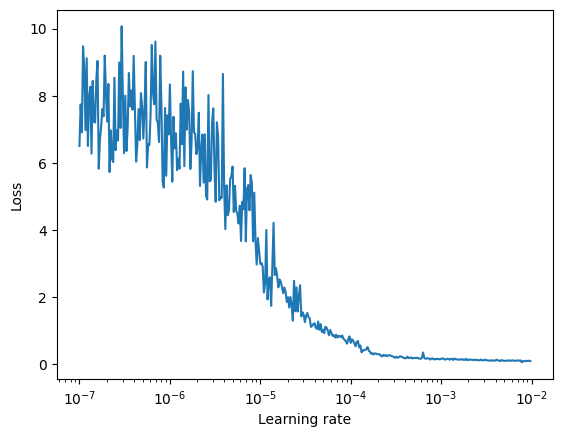

In [ ]:
# Learning rate finder
import math

optimizer = AdamW(t5_small_model.parameters(), lr=1e-7)
min_lr = 1e-7
max_lr = 1e-2
num_steps = len(train_dataloader) * epochs

# learning rate scheduler
lr_lambda = lambda step: math.exp((math.log(max_lr / min_lr) / num_steps) * step)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# gradually increasing the learning rate
t5_small_model.train()
losses = []
lrs = []
for epoch in range(epochs):
    epoch_loss = 0
    for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch}")):
        # learning rate for the current batch
        lr = optimizer.param_groups[0]['lr']
        lrs.append(lr)

        # Train on the current batch
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = t5_small_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # loss for the current batch
        losses.append(loss.item())

# Plot the learning rate against the loss
import matplotlib.pyplot as plt
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.show()


In [ ]:
# Open a CSV file to write the output sentences
import csv 

with open('t5-output-epochs.csv', mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    # Write the header row
    writer.writerow(['Prompt', 'Output'])

    # Generate story endings
    # for i in range(10):
    for input_sentence, actual_ending in zip(x_test_sub, y_test_sub):
        # input_sentence = x_test_sub[i]
        # actual_ending = y_test_sub[i]
        
        # Generate the story ending
        input_text = 'Complete the story: ' + input_sentence
        input_ids = t5_tokenizer.encode(input_text, return_tensors='pt').to(device)
        outputs = t5_small_model_epoch.generate(input_ids=input_ids, max_length=75, num_beams=5, early_stopping=True)
        generated_ending = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
        # Split the output text into sentences and pick the first sentence
        output_sentence = generated_ending.split(".")[0]

        # Print the input sentence, actual ending, and generated ending
        # print('Input sentence:', input_sentence)
        # print('Actual ending:', actual_ending)
        # print('Generated ending:', output_sentence)
        # print()

        # Write the output sentence to the CSV file
        writer.writerow([input_sentence, output_sentence])

csv_file.close()

In [ ]:
# Fine-tune pass#2 - SGD optimizer

t5_small_model_sgd = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

batch_size = 8
learning_rate = 3e-5
epochs = 2

# training dataset and dataloader
train_dataset = StoryDataset(x_train_sub, y_train_sub, t5_tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.SGD(t5_small_model_sgd.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

# Train
t5_small_model_sgd.train()
for epoch in range(epochs):
    epoch_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = t5_small_model_sgd(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch} loss: {epoch_loss/len(train_dataloader):.4f}")


Epoch 0:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 0 loss: 18.0232


Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1 loss: 17.8957


In [ ]:
# Open a CSV file to write the output sentences
with open('t5-output-sgd.csv', mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    # Write the header row
    writer.writerow(['Prompt', 'Output'])

    # Generate story endings
    # for i in range(10):
    #     input_sentence = x_test_sub[i]
    #     actual_ending = y_test_sub[i]
    for input_sentence, actual_ending in zip(x_test_sub, y_test_sub):
        
        # Generate the story ending
        input_text = 'Complete the story: ' + input_sentence
        input_ids = t5_tokenizer.encode(input_text, return_tensors='pt').to(device)
        outputs = t5_small_model_sgd.generate(input_ids=input_ids, max_length=75, num_beams=5, early_stopping=True)
        generated_ending = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
        # Split the output text into sentences and pick the first sentence
        output_sentence = generated_ending.split(".")[0]

        # Print the input sentence, actual ending, and generated ending
        # print('Input sentence:', input_sentence)
        # print('Actual ending:', actual_ending)
        # print('Generated ending:', output_sentence)
        # print()

        # Write the output sentence to the CSV file
        writer.writerow([input_sentence, output_sentence])

csv_file.close()

In [ ]:
# Fine-tune pass#3 - Dropout

from transformers import T5Config
from torch.nn import Dropout2d, Dropout

batch_size = 8
learning_rate = 3e-5
epochs = 2
dropout_rate = 0.2

t5_config = T5Config.from_pretrained('t5-small', dropout_rate=dropout_rate)
t5_small_dropout_model = T5ForConditionalGeneration.from_pretrained('t5-small', config=t5_config).to(device)

# training dataset and dataloader
train_dataset = StoryDataset(x_train_sub, y_train_sub, t5_tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.SGD(t5_small_dropout_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

# Train
t5_small_dropout_model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = t5_small_dropout_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch} loss: {epoch_loss/len(train_dataloader):.4f}")


Epoch 0:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 0 loss: 17.3173


Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1 loss: 17.1700


In [ ]:
# Open a CSV file to write the output sentences
with open('t5-output-dropout.csv', mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    # Write the header row
    writer.writerow(['Prompt', 'Output'])

    # Generate story endings
    # for i in range(10):
    #     input_sentence = x_test_sub[i]
    #     actual_ending = y_test_sub[i]
    for input_sentence, actual_ending in zip(x_test_sub, y_test_sub):
        
        # Generate the story ending
        input_text = 'Complete the story: ' + input_sentence
        input_ids = t5_tokenizer.encode(input_text, return_tensors='pt').to(device)
        outputs = t5_small_dropout_model.generate(input_ids=input_ids, max_length=75, num_beams=5, early_stopping=True)
        generated_ending = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
        # Split the output text into sentences and pick the first sentence
        output_sentence = generated_ending.split(".")[0]

        # Print the input sentence, actual ending, and generated ending
        # print('Input sentence:', input_sentence)
        # print('Actual ending:', actual_ending)
        # print('Generated ending:', output_sentence)
        # print()

        # Write the output sentence to the CSV file
        writer.writerow([input_sentence, output_sentence])

csv_file.close()

#### T5 Model Evaluation:
- BLEURT
- ROUGE

In [ ]:
!pip install git+https://github.com/google-research/bleurt.git

In [ ]:
import torch
import bleurt
from bleurt import score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bleurt_scorer = score.BleurtScorer()

# Evaluate the model on the validation set
scores = []

# Generate story endings
for input_sentence, actual_ending in zip(x_test_sub, y_test_sub):
    
    # Generate the story ending
    input_text = 'Complete the story: ' + input_sentence
    input_ids = t5_tokenizer.encode(input_text, return_tensors='pt').to(device)
    outputs = t5_small_model.generate(input_ids=input_ids, max_length=75, num_beams=5, early_stopping=True)
    generated_ending = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Split the output text into sentences and pick the first sentence
    output_sentence = generated_ending.split(".")[0]

    # Compute the BLEURT score
    bleurt_score = bleurt_scorer.score(references=[output_sentence], candidates=[actual_ending])[0]
    scores.append(bleurt_score)

    # Print the input sentence, actual ending, and generated ending
    # print('Input sentence:', input_sentence)
    # print('Actual ending:', actual_ending)
    # print('Generated ending:', output_sentence)
    # print()

# Compute the average BLEURT score
avg_bleurt_score = sum(scores) / len(scores)
print("Average BLEURT score:", avg_bleurt_score)


Average BLEURT score: -1.0727767089605331


In [ ]:
# Evaluate the model on the validation set
scores = []

# Generate story endings
for input_sentence, actual_ending in zip(x_test_sub, y_test_sub):
    
    # Generate the story ending
    input_text = 'Complete the story: ' + input_sentence
    input_ids = t5_tokenizer.encode(input_text, return_tensors='pt').to(device)
    outputs = t5_small_model_sgd.generate(input_ids=input_ids, max_length=75, num_beams=5, early_stopping=True)
    generated_ending = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Split the output text into sentences and pick the first sentence
    output_sentence = generated_ending.split(".")[0]

    # Compute the BLEURT score
    bleurt_score = bleurt_scorer.score(references=[output_sentence], candidates=[actual_ending])[0]
    scores.append(bleurt_score)

    # Print the input sentence, actual ending, and generated ending
    # print('Input sentence:', input_sentence)
    # print('Actual ending:', actual_ending)
    # print('Generated ending:', output_sentence)
    # print()

# Compute the average BLEURT score
avg_bleurt_score = sum(scores) / len(scores)
print("Average BLEURT score:", avg_bleurt_score)

Average BLEURT score: -1.0657600688040256


In [ ]:
# Evaluate the model on the validation set
scores = []

# Generate story endings
for input_sentence, actual_ending in zip(x_test_sub, y_test_sub):
    
    # Generate the story ending
    input_text = 'Complete the story: ' + input_sentence
    input_ids = t5_tokenizer.encode(input_text, return_tensors='pt').to(device)
    outputs = t5_small_dropout_model.generate(input_ids=input_ids, max_length=75, num_beams=5, early_stopping=True)
    generated_ending = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Split the output text into sentences and pick the first sentence
    output_sentence = generated_ending.split(".")[0]

    # Compute the BLEURT score
    bleurt_score = bleurt_scorer.score(references=[output_sentence], candidates=[actual_ending])[0]
    scores.append(bleurt_score)

    # Print the input sentence, actual ending, and generated ending
    # print('Input sentence:', input_sentence)
    # print('Actual ending:', actual_ending)
    # print('Generated ending:', output_sentence)
    # print()

# Compute the average BLEURT score
avg_bleurt_score = sum(scores) / len(scores)
print("Average BLEURT score:", avg_bleurt_score)


Average BLEURT score: -1.0588932954072952


In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge
rouge = Rouge()

x_test_sub = df_test['X'].astype(str).head(100).values.tolist()
y_test_sub = df_test['sentence5'].astype(str).head(100).values.tolist()

# Define lists to store references and hypothesis
references = []
hypotheses = []

# Generate story endings
for input_sentence, actual_ending in zip(x_test_sub, y_test_sub):
    input_text = "Complete the story: " + input_sentence
    input_ids = t5_tokenizer.encode(input_text, return_tensors="pt").to(device)
    output_ids = t5_small_model.generate(input_ids=input_ids, max_length=75, num_beams=5, early_stopping=True)
    output_text = t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)

    references.append(actual_ending)
    hypotheses.append(output_text)

# Evaluate using ROUGE
scores = rouge.get_scores(hypotheses, references, avg=True)
print(scores)
print()

# Print scores in a prettier format
print("ROUGE-1: ")
print(f"  Precision: {scores['rouge-1']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-1']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-1']['f']*100:.2f}%\n")
print("ROUGE-2: ")
print(f"  Precision: {scores['rouge-2']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-2']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-2']['f']*100:.2f}%\n")
print("ROUGE-L: ")
print(f"  Precision: {scores['rouge-l']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-l']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-l']['f']*100:.2f}%")


{'rouge-1': {'r': 0.320148185148185, 'p': 0.14266573615662614, 'f': 0.18991557575853346}, 'rouge-2': {'r': 0.07056812631812633, 'p': 0.026364789360737842, 'f': 0.03649159405418163}, 'rouge-l': {'r': 0.2988952158952158, 'p': 0.13253944125298456, 'f': 0.17638228814298423}}

ROUGE-1: 
  Precision: 14.27%
  Recall: 32.01%
  F1 score: 18.99%

ROUGE-2: 
  Precision: 2.64%
  Recall: 7.06%
  F1 score: 3.65%

ROUGE-L: 
  Precision: 13.25%
  Recall: 29.89%
  F1 score: 17.64%


In [ ]:
# Define lists to store references and hypothesis
references = []
hypotheses = []

# Generate story endings
for input_sentence, actual_ending in zip(x_test_sub, y_test_sub):
    input_text = "Complete the story: " + input_sentence
    input_ids = t5_tokenizer.encode(input_text, return_tensors="pt").to(device)
    output_ids = t5_small_model_sgd.generate(input_ids=input_ids, max_length=75, num_beams=5, early_stopping=True)
    output_text = t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)

    references.append(actual_ending)
    hypotheses.append(output_text)

# Evaluate using ROUGE
scores = rouge.get_scores(hypotheses, references, avg=True)
print(scores)
print()

# Print scores in a prettier format
print("ROUGE-1: ")
print(f"  Precision: {scores['rouge-1']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-1']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-1']['f']*100:.2f}%\n")
print("ROUGE-2: ")
print(f"  Precision: {scores['rouge-2']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-2']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-2']['f']*100:.2f}%\n")
print("ROUGE-L: ")
print(f"  Precision: {scores['rouge-l']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-l']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-l']['f']*100:.2f}%")

{'rouge-1': {'r': 0.2945450105450104, 'p': 0.15544195634454985, 'f': 0.19447825450269784}, 'rouge-2': {'r': 0.052843517593517596, 'p': 0.02527396394802842, 'f': 0.032511018282458906}, 'rouge-l': {'r': 0.2723162115662115, 'p': 0.14379765752883472, 'f': 0.1794868080186477}}

ROUGE-1: 
  Precision: 15.54%
  Recall: 29.45%
  F1 score: 19.45%

ROUGE-2: 
  Precision: 2.53%
  Recall: 5.28%
  F1 score: 3.25%

ROUGE-L: 
  Precision: 14.38%
  Recall: 27.23%
  F1 score: 17.95%


In [ ]:
# Define lists to store references and hypothesis
references = []
hypotheses = []

# Generate story endings
for input_sentence, actual_ending in zip(x_test_sub, y_test_sub):
    input_text = "Complete the story: " + input_sentence
    input_ids = t5_tokenizer.encode(input_text, return_tensors="pt").to(device)
    output_ids = t5_small_dropout_model.generate(input_ids=input_ids, max_length=75, num_beams=5, early_stopping=True)
    output_text = t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)

    references.append(actual_ending)
    hypotheses.append(output_text)

# Evaluate using ROUGE
scores = rouge.get_scores(hypotheses, references, avg=True)
print(scores)
print()

# Print scores in a prettier format
print("ROUGE-1: ")
print(f"  Precision: {scores['rouge-1']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-1']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-1']['f']*100:.2f}%\n")
print("ROUGE-2: ")
print(f"  Precision: {scores['rouge-2']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-2']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-2']['f']*100:.2f}%\n")
print("ROUGE-L: ")
print(f"  Precision: {scores['rouge-l']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-l']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-l']['f']*100:.2f}%")

{'rouge-1': {'r': 0.26201329226329206, 'p': 0.1452660070325569, 'f': 0.17891659270416024}, 'rouge-2': {'r': 0.0565565823065823, 'p': 0.021659506172258456, 'f': 0.02991278714845246}, 'rouge-l': {'r': 0.24488766788766766, 'p': 0.13424093488248479, 'f': 0.16580657093990275}}

ROUGE-1: 
  Precision: 14.53%
  Recall: 26.20%
  F1 score: 17.89%

ROUGE-2: 
  Precision: 2.17%
  Recall: 5.66%
  F1 score: 2.99%

ROUGE-L: 
  Precision: 13.42%
  Recall: 24.49%
  F1 score: 16.58%


#### OPT Decoder



```
Import the Open Pre-Transformer Tokenizer and Model from Hugging Face 
```



In [30]:
opt_tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m", padding_side='left', use_fast = False)
opt_model = TFOPTForCausalLM.from_pretrained("facebook/opt-350m")

All model checkpoint layers were used when initializing TFOPTForCausalLM.

All the layers of TFOPTForCausalLM were initialized from the model checkpoint at facebook/opt-350m.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFOPTForCausalLM for predictions without further training.


### Evaluate 6 OPT Models



```
# Create the 6 permutations of the OPT 350M parameter model that we want to evaluate
#1: Greedy Search
#2: Beam Search with 3 beams + no_repeat_ngram_size = 2
#3: Beam Search with top_k 
#4: Beam Search using top_k + temperature = 0.7
#5: Top_k = 50
#6: Top-p = 0.92

#Run the x_test set through each model to generate text
```



In [ ]:
# Model #1: Greedy Search
#outputs_greedy = opt_model.generate(input_ex, max_length = 75)
#strs = opt_tokenizer.decode(outputs_greedy[0], skip_special_tokens = True)

output_sentences_1 = []

with tf.device('/device:GPU:0'):
  for i in range(100):
    input_ex_1 = opt_tokenizer.encode(x_test[i], return_tensors = 'tf')
    outputs_greedy = opt_model.generate(input_ex_1, max_length = 75)
    strs = opt_tokenizer.decode(outputs_greedy[0], skip_special_tokens = True)
    output_sentences_1.append(strs)

In [ ]:
output_sentences_1

In [ ]:
output_sentences_1[1]

In [ ]:
import csv


with open('/content/gdrive/My Drive/file_model_1_greedy_search.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(output_sentences_1)

In [ ]:
x_test[1]

In [ ]:
y_test[1]

In [ ]:
# Model #2: Beam Search with 3 beams + no_repeat_ngram_size = 2

output_sentences_2 = []

with tf.device('/device:GPU:0'):
  for i in range(100):
    input_ex_1 = opt_tokenizer.encode(x_test[i], return_tensors = 'tf')
    outputs_beam = opt_model.generate(input_ex_1, max_length = 75, num_beams = 3, no_repeat_ngram_size = 2, early_stopping = True)
    strs_2 = opt_tokenizer.decode(outputs_beam[0], skip_special_tokens = True)
    output_sentences_2.append(strs_2)

In [ ]:
output_sentences_2[6]

In [ ]:
y_test[6]

In [ ]:
with open('/content/gdrive/My Drive/file_model_2_beam_search.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(output_sentences_2)

In [ ]:
# Model #3: Beam Search using top k

output_sentences_3 = []

with tf.device('/device:GPU:0'):
  for i in range(100):
    input_ex_3 = opt_tokenizer.encode(x_test[i], return_tensors = 'tf')
    outputs_beam2 = opt_model.generate(input_ex_3, do_sample = True, max_length = 75, top_k = 0)
    strs_3 = opt_tokenizer.decode(outputs_beam2[0], skip_special_tokens = True)
    output_sentences_3.append(strs_3)

In [ ]:
output_sentences_3[10]

In [ ]:
y_test[10]

In [ ]:
with open('/content/gdrive/My Drive/file_model_3_beam_search_2.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(output_sentences_3)

In [ ]:
# Model #4: Beam search using top_k = 0 + temperature = 0.7

output_sentences_4 = []

with tf.device('/device:GPU:0'):
  for i in range(100):
    input_ex_4 = opt_tokenizer.encode(x_test[i], return_tensors = 'tf')
    outputs_beam3 = opt_model.generate(input_ex_4, do_sample = True, max_length = 75, top_k = 0, temperature = 0.7)
    strs_4 = opt_tokenizer.decode(outputs_beam3[0], skip_special_tokens = True)
    output_sentences_4.append(strs_4)


In [ ]:
output_sentences_4[10]

'Mike really wanted to learn how to play piano. So he took lessons from a professional. The professional gave him some scales to practice. Mike practiced the scales for months and months. He then learned to play a simple string version of the song "The Good Life". He also learned to play the guitar. Mike loves playing the guitar. He is very talented and has already'

In [ ]:
y_test[10]

"Now Mike isn't that bad at piano."

In [ ]:
import csv

with open('/content/gdrive/My Drive/file_model_4_beam_search_3.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(output_sentences_4)

In [ ]:
# Model #5: Top_k = 50

output_sentences_5 = []

with tf.device('/device:GPU:0'):
  for i in range(100):
    input_ex_5 = opt_tokenizer.encode(x_test[i], return_tensors = 'tf')
    outputs_top_k = opt_model.generate(input_ex_5, do_sample = True, max_length = 75, top_k = 50)
    strs_5 = opt_tokenizer.decode(outputs_top_k[0], skip_special_tokens = True)
    output_sentences_5.append(strs_5)

In [ ]:
output_sentences_5[10]

'Mike really wanted to learn how to play piano. So he took lessons from a professional. The professional gave him some scales to practice. Mike practiced the scales for months and months. Eventually, Mike put all his scales on one piece of wooden piano stool and practiced his first solo. A few more weeks later, he put all his scales back on his keyboard.\n\n'

In [ ]:
import csv

with open('/content/gdrive/My Drive/file_model_5_top_k.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(output_sentences_5)

In [ ]:
#Model #6: Top_p = 0.92

output_sentences_6 = []

with tf.device('/device:GPU:0'):
  for i in range(100):
    input_ex_6 = opt_tokenizer.encode(x_test[i], return_tensors = 'tf')
    outputs_top_p = opt_model.generate(input_ex_6, do_sample = True, max_length = 75, top_p = 0.92, top_k = 0)
    strs_6 = opt_tokenizer.decode(outputs_top_p[0], skip_special_tokens = True)
    output_sentences_6.append(strs_6)

In [ ]:
output_sentences_6[10]

"Mike really wanted to learn how to play piano. So he took lessons from a professional. The professional gave him some scales to practice. Mike practiced the scales for months and months. Within weeks he mastered the scale and also learned the character within each bar and chord.\nYeah but then he sat down in the other guy's library and listened to a demo for about 30"

In [ ]:
import csv

with open('/content/gdrive/My Drive/file_model_6_top_p.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(output_sentences_6)

### Unpack results of 6 Models from stored CSVs + model output data processing



```
Re-load in the stored model outputs from CSV file.
```



In [ ]:
import csv
#OPT Model 1 Output
with open('/content/gdrive/My Drive/file_model_1_greedy_search.csv', 'r') as file:
    reader = csv.reader(file)
    opt_model_1_greedy = list(reader)[0]

In [ ]:
print(opt_model_1_greedy[0])

My daughter was born last week. I have a ton of pictures to show you. She is so cute. She has a ton of hair. She is so cute. She is so cute. She is so cute. She is so cute. She is so cute. She is so cute. She is so cute. She is so cute. She is so cute.


In [ ]:
#OPT Model 2 Output
with open('/content/gdrive/My Drive/file_model_2_beam_search.csv', 'r') as file:
    reader = csv.reader(file)
    opt_model_2_beam = list(reader)[0]

In [ ]:
print(opt_model_2_beam[0])

My daughter was born last week. I have a ton of pictures to show you. She is so cute. She has a ton of hair.

She is a little girl, but she is the most adorable little thing I've ever seen.


In [ ]:
#OPT Model 3 Output
with open('/content/gdrive/My Drive/file_model_3_beam_search_2.csv', 'r') as file:
    reader = csv.reader(file)
    opt_model_3_beam = list(reader)[0]

In [ ]:
print(opt_model_3_beam[0])

My daughter was born last week. I have a ton of pictures to show you. She is so cute. She has a ton of hair. I love her! She cheeks are a REAL life. And she can stand up. Take a look at her flyaways. Those cheeks, sides and arms are proud. Fit going on crutches can make her heap away


In [ ]:
#OPT Model 4 Output
with open('/content/gdrive/My Drive/file_model_4_beam_search_3.csv', 'r') as file:
    reader = csv.reader(file)
    opt_model_4_beam = list(reader)[0]

In [ ]:
print(opt_model_4_beam[0])

My daughter was born last week. I have a ton of pictures to show you. She is so cute. She has a ton of hair. I have no idea what to do with it all. I'm going to try to get it cleaned up and maybe refill it. So when is she supposed to come home?
The first time is usually the best time for


In [ ]:
#OPT Model 5 Output
with open('/content/gdrive/My Drive/file_model_5_top_k.csv', 'r') as file:
    reader = csv.reader(file)
    opt_model_5_top_k = list(reader)[0]

In [ ]:
print(opt_model_5_top_k[0])

My daughter was born last week. I have a ton of pictures to show you. She is so cute. She has a ton of hair. She has a ton of cute toys. She is super cute.
I know a lot of my kids are obsessed with hair. They play with it constantly even if we don't have any in our house. I can't


In [ ]:
#OPT Model 6 Output
with open('/content/gdrive/My Drive/file_model_6_top_p.csv', 'r') as file:
    reader = csv.reader(file)
    opt_model_6_top_p = list(reader)[0]

In [ ]:
print(opt_model_6_top_p[0])

My daughter was born last week. I have a ton of pictures to show you. She is so cute. She has a ton of hair.

Our little JoJo is now officially A.I. All she knows is that she is smart and cat. Oh and amazing in bed. She loves to cuddle, but it takes a while for her to settle




```
Model Output - Data Processing:
Step 1. Remove any text after the 5th sentence is generated
Ste[ 2. Remove the first 4 sentences (ie the context) from each output
```



In [ ]:
context = x_test[:100]
print(context)

['My daughter was born last week. I have a ton of pictures to show you. She is so cute. She has a ton of hair.', 'Tom was looking forward to the fourth of July holiday. Tom bought fireworks to prepare. Tom set them off during the holiday celebration. Tom had fun setting off the fireworks.', 'A little boy went to the fair by himself. He saw a goldfish as a prize and wanted to win it. He had to throw a ball and knock down some cups. With one mighty throw, he knocked them all down!', 'Electric City Record Company hired Charles as an intern. Three days a week Charles would promote artists to the media by phone. One day Charles was hungry and called in sick to his internship. His boss complained and told him he needed to make a good impression.', "Kay was walking her dog in the park. The dog did its business in the grass in the park. Kay didn't pick up the dog's mess. An officer on patrol gave Kay a warning.", 'Lisa registered her award-winning pet in an important cat show. Lisa was soon di

In [ ]:
#Model 1 Data Processing

new_text_model_1 = []

for i in range(100):
  strs = opt_model_1_greedy[i].replace(context[i],"")
  new_text_model_1.append(strs)

sep = '.'
final_new_text_model_1 = []


for i in range(100):
  stripped = new_text_model_1[i].split(sep,1)[0]
  final_new_text_model_1.append(stripped)
                          
print(final_new_text_model_1)

[' She is so cute', ' Tom was not disappointed', '\n\nThe boy was so proud of himself that he threw the ball at the prize', ' Charles was fired', '\n\n"I\'m sorry, I\'m sorry," Kay said', ' Lisa was so impressed with the cat that she decided to adopt it', '\n\nThe dogs were so excited to be there', '\n\n', ' He was very happy with the car', ' I was in a pit', ' He eventually got a piano and started playing', '\n\nJames was shocked', ' I put them in the dryer', "\nI bought a basketball goal for my son's birthday", ' It was', ' I was so angry', '\n\nKelly is a very sweet girl', '\n\nThe Clarke family is a family of five', ' He then put the dog in the tub', ' I was like "what the fuck is going on?"\nI was in a soccer game and I was like "what the fuck is going on?"  I was like "I\'m', '\n\nTerry was a very good teacher', ' He was fined $500', ' Skip was very happy to meet her', ' I have been using it for about a week now and I am feeling much better', ' I found some that were a little too

In [ ]:
#Model 2 Data Processing

new_text_model_2 = []

for i in range(100):
  strs = opt_model_2_beam[i].replace(context[i],"")
  new_text_model_2.append(strs)

sep = '.'
final_new_text_model_2 = []


for i in range(100):
  stripped = new_text_model_2[i].split(sep,1)[0]
  final_new_text_model_2.append(stripped)
                          
print(final_new_text_model_2)

["\n\nShe is a little girl, but she is the most adorable little thing I've ever seen", '', '\n\nHe was so proud of himself that he threw the cup at the boy', '\n\n“I said, ‘I don’t want to do this', '\n\nThe officer told Kay that she had to clean up her mess or she would be charged with trespassing', '\n\nLisa’s story is a great example of how pets can be used to help people', '\n\nI was so proud of my dog', '', '\n\nHe was so happy to see his dad, he said, “I’m going to be a car salesman', " It was so bad I couldn't breathe", ' Finally, he was able to master them', ' It was from the bank telling him that he had to pay back the loan', ' They were all dirty', "\nThat's pretty cool", " It wasn't, so we gave it some water and let it go", '   I had to go back to work', '\n\nKelly and her husband have been married for over 20 years', '\n\n“We were so excited,” said one of the kids', ' Then he put the do back in the bathtub and washed it again', "\nI'm sorry to hear that", '\n\nTerry had bee

In [ ]:
#Model 3 Data Processing

new_text_model_3 = []

for i in range(100):
  strs = opt_model_3_beam[i].replace(context[i],"")
  new_text_model_3.append(strs)

sep = '.'
final_new_text_model_3 = []


for i in range(100):
  stripped = new_text_model_3[i].split(sep,1)[0]
  final_new_text_model_3.append(stripped)
                          
print(final_new_text_model_3)

[' I love her! She cheeks are a REAL life', ' Nick knew about Tom’s plan to set fire to images but refused', ' That is how impressive the fish was', ' He remembered his last call and grabbed his keys', ' Anactivated dog rider disagreed and rode away', '\n\nI grew up on my parents’ farm', '', ' She came back a day later with a new used stick', ' He got a new Mazda 3', ' I think I got back up ok', ' Noone in the family knew what to use so Mike discovered the keyboard that was unlocked for free in a dumpster', ' James said that it was about his business', ' There were heels', '\nNow you know why parents have plastic bumpers for their triplets', ' When we spent 3 hours, we saw it was mutilated, and wanting to go home', " I'm pretty sure my boss didn't give me a hard time about it! :)\ni would just take thoseDays off of your job even if there", ' As you can tell, PetLand is a veteran and veteran dog care provider', ' Jacqueline was thrilled to know Winnie Gabrielle Clarke and Quinn Heinsole

In [ ]:
#Model 4 Data Processing

new_text_model_4 = []

for i in range(100):
  strs = opt_model_4_beam[i].replace(context[i],"")
  new_text_model_4.append(strs)

sep = '.'
final_new_text_model_4 = []


for i in range(100):
  stripped = new_text_model_4[i].split(sep,1)[0]
  final_new_text_model_4.append(stripped)
                          
print(final_new_text_model_4)

[' I have no idea what to do with it all', ' Tom wanted to see how many fireworks he could take off during the holiday celebration', ' The goldfish was eaten by other children and the boy was left penniless', ' Charles didn’t have any production experience and was worried he would be turned down', ' She was arrested', '\nLisa was an excellent pet owner, but she has now been diagnosed with the condition of fleas', '\n\nThe dogs were so excited! They ran around the finish line, looking for the Golden Retriever!\n\nThe Golden Retriever was so excited', ' She threw them in the garbage', ' He drove home and told him he was going to find a new car', '\nIf you were a horse rider, which was your favorite?\nI rode a horse to school everyday', ' He then learned to play a simple string version of the song "The Good Life"', '\n\nPraying for more from J', ' They were all loose', " I was just wondering if that was something you ever made if you had kids or just a game and didn't want to ruin it", ' 

In [ ]:
#Model 5 Data Processing

new_text_model_5 = []

for i in range(100):
  strs = opt_model_5_top_k[i].replace(context[i],"")
  new_text_model_5.append(strs)

sep = '.'
final_new_text_model_5 = []


for i in range(100):
  stripped = new_text_model_5[i].split(sep,1)[0]
  final_new_text_model_5.append(stripped)
                          
print(final_new_text_model_5)

[' She has a ton of cute toys', ' So, the following morning, Tom made the trip back to his home in Connecticut', ' When he was done with this, a goldfish was thrown in his face and then he jumped on his bed', " When he hung up with his boss, he learned that Charles was in love with the girl he'd slept with", " Kay did not pick up the dog's mess, so the officer left the dog alone", " Lisa then found that her cat's fleas had spread to her other animals - so she found herself", ' It was their first time competing', ' A man went to the bathroom to check it out', ' So there was the chance for him to buy a new Cadillac', ' The people I was following tried to run after me', ' Eventually, Mike put all his scales on one piece of wooden piano stool and practiced his first solo', ' He was still waiting at the post office, but when he opened it up he noticed it said he already had a big night', ' I stood over her, I took the towel of the trash can', ' It also contained an interesting tip', ' Well,

In [ ]:
#Model 6 Data Processing

new_text_model_6 = []

for i in range(100):
  strs = opt_model_6_top_p[i].replace(context[i],"")
  new_text_model_6.append(strs)

sep = '.'
final_new_text_model_6 = []


for i in range(100):
  stripped = new_text_model_6[i].split(sep,1)[0]
  final_new_text_model_6.append(stripped)
                          
print(final_new_text_model_6)

['\n\nOur little JoJo is now officially A', ' Tom woke up to see the fireworks going off', '\nThrowing out a few cups is one thing, knocking down an entire thing is a whole other level of humiliation', ' Charles said: “It was supposed to be my last day on the job', '\n\nPolice officers called to the scene told Kay a ticket and fine would be issued if the dog was not taken care of', ' Lisa continued to inquire to each of the local showcats who have not received the award', ' He was a 5 minute favorite and won out in a close 5 minute run', " Don't look back", ' Their son asked, "Are you making a choice?" He was cool, and decided that he wanted to buy his first car', " I didn't get up because of a huge shock", ' Within weeks he mastered the scale and also learned the character within each bar and chord', ' In that letter, the Cashier writes:\n\n“Hi,\n\nSince your Dansby came in and came', ' I went to the toilet', " Thankfully, he had his father's set at home", ' A few minutes into the loo

### OPT Model Evaluation for 6 candidate models:
- BLEURT
- ROUGE

In [ ]:
sample_y_test = y_test[:100]
print(len(sample_y_test))

100


In [ ]:
#BLEURT SCORES
# Set tf.enable_eager_execution() if using TF 1.x.
import tensorflow as tf
print(tf.__version__)

!pip install --upgrade pip

2.12.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install git+https://github.com/google-research/bleurt.git

import bleurt
from bleurt import score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/google-research/bleurt.git to /tmp/pip-req-build-qr95x52c
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/bleurt.git /tmp/pip-req-build-qr95x52c
  Resolved https://github.com/google-research/bleurt.git to commit cebe7e6f996b40910cfaa520a63db47807e3bf5c
  Preparing metadata (setup.py) ... done


In [ ]:
# MODEL 1 BLEURT SCORE
references = tf.constant(sample_y_test) #correct results
candidates = tf.constant(final_new_text_model_1) #generated 5th sentence

bleurt_ops = score.create_bleurt_ops()
bleurt_out = bleurt_ops(references=references, candidates=candidates)

assert bleurt_out["predictions"].shape == (100,)
print(bleurt_out["predictions"],'\n')
print("Model 1 Average BLEURT score: ", sum(bleurt_out["predictions"])/100)

tf.Tensor(
[-1.2157799  -1.2265493  -0.64851594 -1.4661039  -1.10088    -0.9568354
 -0.9505153  -0.6815118  -0.8329398  -1.192654   -0.9583416  -1.2905662
  0.28435266 -0.86292386 -1.372221   -1.3092967  -1.1455305  -1.1660621
 -1.4121001  -1.2503706  -1.1469806  -1.2709522  -1.018607   -0.2527153
 -0.8895     -0.15892552 -0.6386502  -0.8925196  -0.53281784 -1.1649461
 -1.2342728  -1.3638741  -1.0887622  -0.15455042 -0.8941685  -0.8570709
 -1.2234477  -0.7785666  -1.079416   -0.7718033  -0.96762896 -0.6139575
 -0.94218135 -1.305049   -1.240885   -0.40079618 -1.026025   -0.9622556
 -1.27455    -1.1030741  -1.1213263  -0.72532606 -0.63269067 -1.2125586
 -1.0435271  -0.86842906 -0.8458316  -0.86912966 -1.1044677  -1.1630878
 -0.8182592  -1.2075309  -1.1919779  -1.0843589  -1.1411308  -1.3908075
 -1.1148014  -1.1094754  -1.0200665  -1.2330025  -0.08044253 -0.7116399
 -1.1753924  -0.16117303 -1.1725665  -1.0912305  -0.8078202  -1.0365735
 -1.2733824  -1.3113319  -1.1052241  -1.0255418  -0.8

In [ ]:
# MODEL 2 BLEURT SCORE
references = tf.constant(sample_y_test)
candidates = tf.constant(final_new_text_model_2)

bleurt_ops = score.create_bleurt_ops()
bleurt_out = bleurt_ops(references=references, candidates=candidates)

assert bleurt_out["predictions"].shape == (100,)
print(bleurt_out["predictions"],'\n')
print("Model 2 Average BLEURT score: ", sum(bleurt_out["predictions"])/100)

tf.Tensor(
[-1.027638   -0.6424663  -0.6896586  -1.2523313  -0.81016666 -0.9951893
 -0.93707633 -0.6815118  -1.3390781  -1.290237   -1.1873058  -0.87273765
 -1.3148944  -1.27468    -1.1499016  -1.2217343  -0.7362255  -1.0753739
 -1.2419193  -1.2432534  -0.8742819  -0.95574975 -1.2427306  -0.36997253
 -1.092231   -0.60869604 -0.4234683  -1.2702246  -0.71444315 -1.0898433
 -1.0194882  -1.1685803  -0.69388825 -0.619557   -0.9582665  -0.9303763
 -1.1979587  -1.1405414  -0.82565933 -1.0232444  -1.0991367  -0.9454274
 -0.86045074 -1.3317534  -1.0672331  -0.7023822  -1.0227181  -0.98363805
 -1.27455    -0.62247705 -1.116768   -1.0250324  -0.87248766 -1.1895394
 -0.5572238  -0.663553   -1.2045529  -1.1060491  -0.73382026 -0.85426736
 -1.2368853  -0.6654048  -1.1862209  -1.3112667  -0.64146227 -1.114769
 -1.1578668  -0.934726   -0.9231175  -1.2861302  -0.9015864  -1.0263767
 -1.1625888  -1.1890118  -1.0581897  -1.1425062  -1.1417967  -0.99180543
 -1.1916003  -1.1232346  -1.1419561  -1.0965896  

In [ ]:
# MODEL 3 BLEURT SCORE
references = tf.constant(sample_y_test)
candidates = tf.constant(final_new_text_model_3)

bleurt_ops = score.create_bleurt_ops()
bleurt_out = bleurt_ops(references=references, candidates=candidates)

assert bleurt_out["predictions"].shape == (100,)
print(bleurt_out["predictions"],'\n')
print("Model 3 Average BLEURT score: ", sum(bleurt_out["predictions"])/100)

tf.Tensor(
[-0.75852734 -0.6416314  -0.88765216 -1.3390914  -0.917889   -1.2200689
 -0.7077422  -0.99569476 -1.0658015  -1.2091674  -0.8433762  -1.2388344
 -1.4307382  -1.1498257  -1.2450916  -0.6895281  -1.1001987  -0.8619844
 -1.2618916  -1.0659101  -1.1282539  -0.9186189  -1.2405839  -1.0977727
 -0.72207123 -0.6186376  -1.3462635  -1.0143019  -1.1515478  -0.9561467
 -0.9428048  -1.3095828  -1.1391679  -0.34752548 -0.81910133 -0.93064
 -0.89053595 -0.8108004  -0.94942987 -0.7906295  -1.2115693  -1.2048163
 -1.1944423  -1.5261534  -1.1568208  -1.226746   -0.85015476 -1.1138191
 -0.6605757  -1.1845641  -1.1356566  -0.95951486 -0.9460095  -1.1241368
 -0.9290831  -1.1387502  -0.84824103 -1.1919274  -0.61585677 -0.52274245
 -1.1406932  -0.60933006 -1.2221389  -1.4279314  -1.0328474  -0.97850263
 -1.1670642   0.03381081 -1.1508002  -1.4062266  -0.7642695  -0.9241693
 -1.0595182  -1.2229702  -1.125017   -1.0466412  -1.1860219  -1.2786896
 -0.8724885  -1.1337991  -1.1642928  -1.2351087  -1.1

In [ ]:
# MODEL 4 BLEURT SCORE
references = tf.constant(sample_y_test)
candidates = tf.constant(final_new_text_model_4)

bleurt_ops = score.create_bleurt_ops()
bleurt_out = bleurt_ops(references=references, candidates=candidates)

assert bleurt_out["predictions"].shape == (100,)
print(bleurt_out["predictions"],'\n')
print("Model 4 Average BLEURT score: ", sum(bleurt_out["predictions"])/100)

tf.Tensor(
[-1.0389299   0.00393595 -0.6040432  -0.92763233 -1.3611912  -0.9629967
 -0.92085755 -1.268786   -1.1213137  -0.83664554 -0.9571351  -1.4185281
 -1.363746   -1.0260801  -1.0715747  -1.2990168  -0.94552684 -1.0192542
 -1.3115042  -0.7515124  -0.8833777  -1.243118   -1.1097214  -0.00171755
 -1.005441   -0.6079024  -1.1020669  -1.0794709  -1.0715175  -1.0755408
 -1.039755   -1.084064   -0.96007884 -0.63131255 -1.1032679  -0.69264865
 -0.46852094 -1.1518131  -0.85224843 -0.6256691  -0.81670976 -0.972855
 -0.61802095 -1.0411339  -1.1626697  -0.9466665  -0.9612969  -0.6930818
 -1.286552   -1.342516   -1.1966732  -1.1733711  -0.95646286 -1.2150671
 -0.9172554  -1.0995765  -1.2320247  -0.87915945 -0.78409344 -1.2585578
 -1.0373962  -0.91979265 -1.2134131  -1.3310573  -1.1716967  -1.0499223
 -1.092852   -0.76166636 -1.1249816  -0.40269947 -0.9039762  -1.2742839
 -1.3499875  -0.926883   -0.81573296 -1.0766811  -1.041484   -0.3959949
 -1.0060899  -1.3466914  -1.1633122  -1.0535319  -0.

In [ ]:
# MODEL 5 BLEURT SCORE
references = tf.constant(sample_y_test)
candidates = tf.constant(final_new_text_model_5)

bleurt_ops = score.create_bleurt_ops()
bleurt_out = bleurt_ops(references=references, candidates=candidates)

assert bleurt_out["predictions"].shape == (100,)
print(bleurt_out["predictions"],'\n')
print("Model 5 Average BLEURT score: ", sum(bleurt_out["predictions"])/100)

tf.Tensor(
[-1.1484698  -0.8783206  -0.497311   -1.212075   -0.14835511 -1.1375761
 -1.2151958  -0.9591379  -0.83912146 -1.0052004  -0.80968606 -0.93732214
 -0.44110256 -1.191644   -1.4435529  -0.8615242  -0.8687006  -0.95135117
 -1.0896617  -1.0007038  -0.8213713  -0.6998141  -0.892822   -0.82583964
 -0.85364246  0.15686081 -0.8417259  -1.2498777  -1.1147549  -1.0326962
 -0.5766632  -1.1090473  -1.1994034  -0.8542334  -0.98498344 -0.9569018
 -1.0847664  -1.1462729  -1.0370991  -0.47341263 -1.0605178  -0.8302187
 -0.9519247  -1.0032556  -0.9187317  -1.2949786  -0.6983947  -0.9615303
 -0.57856596 -1.0841495  -1.1130087  -1.1193558  -0.9919832  -0.6169771
 -0.5572238  -1.2592337  -0.8723495  -1.0194666  -0.8184623  -1.2559547
 -0.6210338  -0.71794087 -1.0903937  -0.59142476 -0.57543504 -0.8359643
 -1.1401603  -0.37067342 -1.0238984  -1.0451491  -0.866042   -1.0396767
 -1.1881284  -0.9475155  -0.65030944 -1.0160089  -1.1210264  -1.0487754
 -0.83457243 -1.0148578  -1.2850422  -1.0302503  -

In [ ]:
# MODEL 6 BLEURT SCORE
references = tf.constant(sample_y_test)
candidates = tf.constant(final_new_text_model_6)

bleurt_ops = score.create_bleurt_ops()
bleurt_out = bleurt_ops(references=references, candidates=candidates)

assert bleurt_out["predictions"].shape == (100,)
print(bleurt_out["predictions"],'\n')
print("Model 6 Average BLEURT score: ", sum(bleurt_out["predictions"])/100) #this where avg tensor outputs.

#highest positive float value is best.

tf.Tensor(
[-1.1698707  -0.7151295  -0.9972018  -1.1872859  -0.53989506 -0.8553822
 -1.0221639  -1.3567832  -1.2261337  -1.2168227  -0.9572176  -1.05911
 -0.55905473 -0.96427715 -1.0616553  -0.54732925 -1.2099507  -1.1933687
 -0.60583615 -1.2911842  -0.95218897 -1.027845   -1.0693182  -0.8754225
 -1.134627   -0.7984157  -1.0603733  -0.4267547  -0.9959943  -0.14522953
 -1.2672532  -0.8978188  -1.0526447  -0.6756853  -0.7593403  -0.95030785
 -0.777262   -1.0752606  -0.91675615 -0.9882302  -0.9543824  -1.1994307
 -1.0668378  -1.1257691  -1.0842487  -0.562589   -1.0457656  -1.20894
 -1.1662209  -1.113362   -1.1382716  -1.0248251  -0.6790253  -1.271619
 -1.2045394  -1.1671982  -1.1207657  -0.69716483 -0.4110648   0.02149938
 -1.4225028  -1.1211499  -1.3101563  -1.1145542  -0.80959755 -1.02982
 -1.3333454  -1.2410386  -0.88371813 -1.1868031  -0.17142795 -1.0547498
 -1.1223537  -0.97551537 -1.2013793  -0.90107024 -1.2171926  -0.9724039
 -1.1403733  -1.2966402  -1.1912042  -1.1992188  -0.78640

In [ ]:
# ROUGE SCORES
!pip install rouge
from rouge import Rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Model 1 ROUGE SCORES

rouge = Rouge()

# Generate a set of sentences from your model
generated_sentences = final_new_text_model_1

# Provide a set of reference sentences to compare against
reference_sentences = sample_y_test

# Compute the ROUGE scores
scores = rouge.get_scores(generated_sentences, reference_sentences, avg=True)

# Print scores in a prettier format
print("Model 1 ROUGE scores")
print("ROUGE-1: ")
print(f"  Precision: {scores['rouge-1']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-1']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-1']['f']*100:.2f}%\n")
print("ROUGE-2: ")
print(f"  Precision: {scores['rouge-2']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-2']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-2']['f']*100:.2f}%\n")
print("ROUGE-L: ")
print(f"  Precision: {scores['rouge-l']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-l']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-l']['f']*100:.2f}%")

Model 1 ROUGE scores
ROUGE-1: 
  Precision: 17.25%
  Recall: 15.25%
  F1 score: 15.18%

ROUGE-2: 
  Precision: 3.59%
  Recall: 3.57%
  F1 score: 3.38%

ROUGE-L: 
  Precision: 16.61%
  Recall: 14.55%
  F1 score: 14.52%


In [ ]:
#Model 2 ROUGE SCORES

from rouge import Rouge

rouge = Rouge()

# Generate a set of sentences from your model
generated_sentences = final_new_text_model_2

# Provide a set of reference sentences to compare against
reference_sentences = sample_y_test

# Compute the ROUGE scores
scores = rouge.get_scores(generated_sentences, reference_sentences, avg=True, ignore_empty = True)

# Print scores in a prettier format
print("Model 1 ROUGE scores")
print("ROUGE-1: ")
print(f"  Precision: {scores['rouge-1']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-1']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-1']['f']*100:.2f}%\n")
print("ROUGE-2: ")
print(f"  Precision: {scores['rouge-2']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-2']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-2']['f']*100:.2f}%\n")
print("ROUGE-L: ")
print(f"  Precision: {scores['rouge-l']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-l']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-l']['f']*100:.2f}%")

Model 1 ROUGE scores
ROUGE-1: 
  Precision: 9.92%
  Recall: 11.13%
  F1 score: 9.65%

ROUGE-2: 
  Precision: 0.95%
  Recall: 0.74%
  F1 score: 0.71%

ROUGE-L: 
  Precision: 9.23%
  Recall: 10.25%
  F1 score: 8.88%


In [ ]:
#Model 3 ROUGE SCORES

rouge = Rouge()

# Generate a set of sentences from your model
generated_sentences = final_new_text_model_3

# Provide a set of reference sentences to compare against
reference_sentences = sample_y_test

# Compute the ROUGE scores
scores = rouge.get_scores(generated_sentences, reference_sentences, avg=True, ignore_empty = True)

# Print scores in a prettier format
print("Model 1 ROUGE scores")
print("ROUGE-1: ")
print(f"  Precision: {scores['rouge-1']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-1']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-1']['f']*100:.2f}%\n")
print("ROUGE-2: ")
print(f"  Precision: {scores['rouge-2']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-2']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-2']['f']*100:.2f}%\n")
print("ROUGE-L: ")
print(f"  Precision: {scores['rouge-l']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-l']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-l']['f']*100:.2f}%")

Model 1 ROUGE scores
ROUGE-1: 
  Precision: 8.23%
  Recall: 10.75%
  F1 score: 8.54%

ROUGE-2: 
  Precision: 0.39%
  Recall: 0.94%
  F1 score: 0.53%

ROUGE-L: 
  Precision: 7.25%
  Recall: 9.94%
  F1 score: 7.68%


In [ ]:
#Model 4 ROUGE SCORES

rouge = Rouge()

# Generate a set of sentences from your model
evaluated_sentences = final_new_text_model_4

# Provide a set of reference sentences to compare against
reference_sentences = sample_y_test

# Compute the ROUGE scores
scores = rouge.get_scores(generated_sentences, evaluated_sentences, avg=True, ignore_empty = True)

# Print scores in a prettier format
print("Model 1 ROUGE scores")
print("ROUGE-1: ")
print(f"  Precision: {scores['rouge-1']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-1']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-1']['f']*100:.2f}%\n")
print("ROUGE-2: ")
print(f"  Precision: {scores['rouge-2']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-2']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-2']['f']*100:.2f}%\n")
print("ROUGE-L: ")
print(f"  Precision: {scores['rouge-l']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-l']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-l']['f']*100:.2f}%")

Model 1 ROUGE scores
ROUGE-1: 
  Precision: 11.76%
  Recall: 11.45%
  F1 score: 10.49%

ROUGE-2: 
  Precision: 0.86%
  Recall: 0.79%
  F1 score: 0.78%

ROUGE-L: 
  Precision: 10.78%
  Recall: 10.20%
  F1 score: 9.43%


In [ ]:
#Model 5 ROUGE SCORES

rouge = Rouge()

# Generate a set of sentences from your model
generated_sentences = final_new_text_model_5

# Provide a set of reference sentences to compare against
reference_sentences = sample_y_test

# Compute the ROUGE scores
scores = rouge.get_scores(generated_sentences, reference_sentences, avg=True, ignore_empty = True)

# Print scores in a prettier format
print("Model 1 ROUGE scores")
print("ROUGE-1: ")
print(f"  Precision: {scores['rouge-1']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-1']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-1']['f']*100:.2f}%\n")
print("ROUGE-2: ")
print(f"  Precision: {scores['rouge-2']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-2']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-2']['f']*100:.2f}%\n")
print("ROUGE-L: ")
print(f"  Precision: {scores['rouge-l']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-l']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-l']['f']*100:.2f}%")

Model 1 ROUGE scores
ROUGE-1: 
  Precision: 10.11%
  Recall: 14.01%
  F1 score: 11.21%

ROUGE-2: 
  Precision: 0.68%
  Recall: 1.10%
  F1 score: 0.78%

ROUGE-L: 
  Precision: 9.25%
  Recall: 12.87%
  F1 score: 10.25%


In [ ]:
#Model 6 ROUGE SCORES

rouge = Rouge()

# Generate a set of sentences from your model
generated_sentences = final_new_text_model_6

# Provide a set of reference sentences to compare against
reference_sentences = sample_y_test

# Compute the ROUGE scores
scores = rouge.get_scores(generated_sentences, reference_sentences, avg=True, ignore_empty = True)

# Print scores in a prettier format
print("Model 1 ROUGE scores")
print("ROUGE-1: ")
print(f"  Precision: {scores['rouge-1']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-1']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-1']['f']*100:.2f}%\n")
print("ROUGE-2: ")
print(f"  Precision: {scores['rouge-2']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-2']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-2']['f']*100:.2f}%\n")
print("ROUGE-L: ")
print(f"  Precision: {scores['rouge-l']['p']*100:.2f}%")
print(f"  Recall: {scores['rouge-l']['r']*100:.2f}%")
print(f"  F1 score: {scores['rouge-l']['f']*100:.2f}%")

Model 1 ROUGE scores
ROUGE-1: 
  Precision: 8.79%
  Recall: 11.72%
  F1 score: 9.35%

ROUGE-2: 
  Precision: 0.35%
  Recall: 0.63%
  F1 score: 0.42%

ROUGE-L: 
  Precision: 7.79%
  Recall: 10.54%
  F1 score: 8.32%


## Options for batch processing for OPT

In [46]:
#Option 1 for batch processing 
opt_input_ex = opt_tokenizer.batch_encode_plus(x_test[:100],
              max_length=75,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
opt_input_ex

{'input_ids': <tf.Tensor: shape=(100, 75), dtype=int32, numpy=
array([[    1,     1,     1, ...,     9,  2549,     4],
       [    1,     1,     1, ...,     5, 10756,     4],
       [    1,     1,     1, ...,    70,   159,   328],
       ...,
       [    1,     1,     1, ...,     5,  4081,     4],
       [    1,     1,     1, ...,   793,    65,     4],
       [    1,     1,     1, ...,    10,  4758,     4]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(100, 75), dtype=int32, numpy=
array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=int32)>}

In [47]:
outputs_greedy = opt_model.generate(**opt_input_ex, max_length = 100)
strs = opt_tokenizer.batch_decode(outputs_greedy, skip_special_tokens = True)

In [48]:
print(strs)

['My daughter was born last week. I have a ton of pictures to show you. She is so cute. She has a ton of hair. She is so cute. She is so cute. She is so cute. She is so cute. She is so cute.', 'Tom was looking forward to the fourth of July holiday. Tom bought fireworks to prepare. Tom set them off during the holiday celebration. Tom had fun setting off the fireworks. Tom was not disappointed. Tom was not disappointed. Tom was not disappointed. Tom was not disappointed. Tom was not disappointed.', 'A little boy went to the fair by himself. He saw a goldfish as a prize and wanted to win it. He had to throw a ball and knock down some cups. With one mighty throw, he knocked them all down!\n\nThe boy was so proud of himself that he threw the ball at the prize. The prize was a goldfish.', 'Electric City Record Company hired Charles as an intern. Three days a week Charles would promote artists to the media by phone. One day Charles was hungry and called in sick to his internship. His boss com